In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(356576, 828)
(356576, 8)
validation
(56520, 828)
(56520, 8)
test
(26800, 828)
(26800, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/36 [..............................] - ETA: 43s - loss: 1.9990 - STD: 0.0692 - MAE: 0.2126

 4/36 [==>...........................] - ETA: 0s - loss: 1.6455 - STD: 0.1335 - MAE: 0.1775 

 5/36 [===>..........................] - ETA: 1s - loss: 1.6085 - STD: 0.1512 - MAE: 0.1701

 6/36 [====>.........................] - ETA: 1s - loss: 1.5835 - STD: 0.1633 - MAE: 0.1651

 7/36 [====>.........................] - ETA: 1s - loss: 1.5638 - STD: 0.1707 - MAE: 0.1619

 8/36 [=====>........................] - ETA: 1s - loss: 1.5513 - STD: 0.1746 - MAE: 0.1602

 9/36 [======>.......................] - ETA: 1s - loss: 1.5376 - STD: 0.1759 - MAE: 0.1594

10/36 [=======>......................] - ETA: 1s - loss: 1.5295 - STD: 0.1758 - MAE: 0.1592

11/36 [========>.....................] - ETA: 1s - loss: 1.5236 - STD: 0.1751 - MAE: 0.1594

12/36 [=========>....................] - ETA: 1s - loss: 1.5193 - STD: 0.1743 - MAE: 0.1596

13/36 [=========>....................] - ETA: 1s - loss: 1.5150 - STD: 0.1738 - MAE: 0.1596

14/36 [==========>...................] - ETA: 1s - loss: 1.5109 - STD: 0.1737 - MAE: 0.1596

15/36 [===========>..................] - ETA: 1s - loss: 1.5073 - STD: 0.1740 - MAE: 0.1594

16/36 [============>.................] - ETA: 1s - loss: 1.5024 - STD: 0.1746 - MAE: 0.1591

17/36 [=============>................] - ETA: 0s - loss: 1.4971 - STD: 0.1755 - MAE: 0.1587

18/36 [==============>...............] - ETA: 0s - loss: 1.4940 - STD: 0.1764 - MAE: 0.1583

19/36 [==============>...............] - ETA: 0s - loss: 1.4905 - STD: 0.1773 - MAE: 0.1579

20/36 [===============>..............] - ETA: 0s - loss: 1.4865 - STD: 0.1781 - MAE: 0.1575

21/36 [================>.............] - ETA: 0s - loss: 1.4831 - STD: 0.1786 - MAE: 0.1572

22/36 [=================>............] - ETA: 0s - loss: 1.4808 - STD: 0.1790 - MAE: 0.1570

23/36 [==================>...........] - ETA: 0s - loss: 1.4789 - STD: 0.1791 - MAE: 0.1570

24/36 [===================>..........] - ETA: 0s - loss: 1.4762 - STD: 0.1789 - MAE: 0.1570

25/36 [===================>..........] - ETA: 0s - loss: 1.4752 - STD: 0.1785 - MAE: 0.1571

26/36 [====================>.........] - ETA: 0s - loss: 1.4732 - STD: 0.1780 - MAE: 0.1573

27/36 [=====================>........] - ETA: 0s - loss: 1.4713 - STD: 0.1773 - MAE: 0.1575

28/36 [======================>.......] - ETA: 0s - loss: 1.4696 - STD: 0.1767 - MAE: 0.1576

29/36 [=======================>......] - ETA: 0s - loss: 1.4684 - STD: 0.1761 - MAE: 0.1578

30/36 [========================>.....] - ETA: 0s - loss: 1.4673 - STD: 0.1757 - MAE: 0.1580

31/36 [========================>.....] - ETA: 0s - loss: 1.4658 - STD: 0.1753 - MAE: 0.1580

32/36 [=========================>....] - ETA: 0s - loss: 1.4643 - STD: 0.1751 - MAE: 0.1581

33/36 [==========================>...] - ETA: 0s - loss: 1.4630 - STD: 0.1751 - MAE: 0.1580

36/36 [==============================] - 4s 90ms/step - loss: 1.4591 - STD: 0.1755 - MAE: 0.1578 - val_loss: 1.4287 - val_STD: 0.1843 - val_MAE: 0.1519


Epoch 2/10000


 1/36 [..............................] - ETA: 2s - loss: 1.4177 - STD: 0.1844 - MAE: 0.1535

 2/36 [>.............................] - ETA: 2s - loss: 1.4110 - STD: 0.1845 - MAE: 0.1531

 3/36 [=>............................] - ETA: 1s - loss: 1.4140 - STD: 0.1843 - MAE: 0.1533

 4/36 [==>...........................] - ETA: 1s - loss: 1.4104 - STD: 0.1838 - MAE: 0.1533

 5/36 [===>..........................] - ETA: 1s - loss: 1.4163 - STD: 0.1832 - MAE: 0.1539

 6/36 [====>.........................] - ETA: 1s - loss: 1.4193 - STD: 0.1823 - MAE: 0.1544

 7/36 [====>.........................] - ETA: 1s - loss: 1.4193 - STD: 0.1813 - MAE: 0.1548

 8/36 [=====>........................] - ETA: 1s - loss: 1.4204 - STD: 0.1802 - MAE: 0.1552

 9/36 [======>.......................] - ETA: 1s - loss: 1.4192 - STD: 0.1792 - MAE: 0.1555

10/36 [=======>......................] - ETA: 1s - loss: 1.4186 - STD: 0.1783 - MAE: 0.1558

11/36 [========>.....................] - ETA: 1s - loss: 1.4174 - STD: 0.1777 - MAE: 0.1560

13/36 [=========>....................] - ETA: 1s - loss: 1.4164 - STD: 0.1772 - MAE: 0.1561

14/36 [==========>...................] - ETA: 1s - loss: 1.4182 - STD: 0.1773 - MAE: 0.1561

15/36 [===========>..................] - ETA: 1s - loss: 1.4171 - STD: 0.1776 - MAE: 0.1560

16/36 [============>.................] - ETA: 1s - loss: 1.4186 - STD: 0.1778 - MAE: 0.1559

17/36 [=============>................] - ETA: 1s - loss: 1.4191 - STD: 0.1781 - MAE: 0.1559

18/36 [==============>...............] - ETA: 1s - loss: 1.4198 - STD: 0.1782 - MAE: 0.1559

19/36 [==============>...............] - ETA: 0s - loss: 1.4203 - STD: 0.1782 - MAE: 0.1559

20/36 [===============>..............] - ETA: 0s - loss: 1.4209 - STD: 0.1780 - MAE: 0.1560

21/36 [================>.............] - ETA: 0s - loss: 1.4205 - STD: 0.1777 - MAE: 0.1561

22/36 [=================>............] - ETA: 0s - loss: 1.4197 - STD: 0.1774 - MAE: 0.1562

23/36 [==================>...........] - ETA: 0s - loss: 1.4192 - STD: 0.1770 - MAE: 0.1563

24/36 [===================>..........] - ETA: 0s - loss: 1.4186 - STD: 0.1767 - MAE: 0.1563

25/36 [===================>..........] - ETA: 0s - loss: 1.4186 - STD: 0.1766 - MAE: 0.1564

26/36 [====================>.........] - ETA: 0s - loss: 1.4179 - STD: 0.1765 - MAE: 0.1564

27/36 [=====================>........] - ETA: 0s - loss: 1.4179 - STD: 0.1765 - MAE: 0.1564

28/36 [======================>.......] - ETA: 0s - loss: 1.4171 - STD: 0.1766 - MAE: 0.1563

29/36 [=======================>......] - ETA: 0s - loss: 1.4159 - STD: 0.1767 - MAE: 0.1562

30/36 [========================>.....] - ETA: 0s - loss: 1.4153 - STD: 0.1767 - MAE: 0.1561

31/36 [========================>.....] - ETA: 0s - loss: 1.4153 - STD: 0.1768 - MAE: 0.1561

32/36 [=========================>....] - ETA: 0s - loss: 1.4144 - STD: 0.1768 - MAE: 0.1561

33/36 [==========================>...] - ETA: 0s - loss: 1.4137 - STD: 0.1768 - MAE: 0.1560

34/36 [===========================>..] - ETA: 0s - loss: 1.4136 - STD: 0.1767 - MAE: 0.1561

35/36 [============================>.] - ETA: 0s - loss: 1.4130 - STD: 0.1766 - MAE: 0.1560

36/36 [==============================] - ETA: 0s - loss: 1.4123 - STD: 0.1766 - MAE: 0.1560

36/36 [==============================] - 2s 62ms/step - loss: 1.4123 - STD: 0.1766 - MAE: 0.1560 - val_loss: 1.3957 - val_STD: 0.1753 - val_MAE: 0.1530


Epoch 3/10000


 1/36 [..............................] - ETA: 3s - loss: 1.3680 - STD: 0.1761 - MAE: 0.1537

 2/36 [>.............................] - ETA: 2s - loss: 1.3740 - STD: 0.1771 - MAE: 0.1536

 4/36 [==>...........................] - ETA: 1s - loss: 1.3784 - STD: 0.1778 - MAE: 0.1536

 5/36 [===>..........................] - ETA: 1s - loss: 1.3767 - STD: 0.1776 - MAE: 0.1535

 6/36 [====>.........................] - ETA: 1s - loss: 1.3761 - STD: 0.1773 - MAE: 0.1535

 7/36 [====>.........................] - ETA: 1s - loss: 1.3750 - STD: 0.1773 - MAE: 0.1534

 8/36 [=====>........................] - ETA: 1s - loss: 1.3737 - STD: 0.1775 - MAE: 0.1532

 9/36 [======>.......................] - ETA: 1s - loss: 1.3723 - STD: 0.1779 - MAE: 0.1530

10/36 [=======>......................] - ETA: 1s - loss: 1.3710 - STD: 0.1784 - MAE: 0.1527

11/36 [========>.....................] - ETA: 1s - loss: 1.3694 - STD: 0.1789 - MAE: 0.1525

12/36 [=========>....................] - ETA: 1s - loss: 1.3675 - STD: 0.1791 - MAE: 0.1523

13/36 [=========>....................] - ETA: 1s - loss: 1.3673 - STD: 0.1792 - MAE: 0.1522

14/36 [==========>...................] - ETA: 1s - loss: 1.3660 - STD: 0.1794 - MAE: 0.1521

15/36 [===========>..................] - ETA: 1s - loss: 1.3666 - STD: 0.1797 - MAE: 0.1520

16/36 [============>.................] - ETA: 1s - loss: 1.3653 - STD: 0.1800 - MAE: 0.1518

17/36 [=============>................] - ETA: 1s - loss: 1.3637 - STD: 0.1803 - MAE: 0.1516

18/36 [==============>...............] - ETA: 1s - loss: 1.3627 - STD: 0.1808 - MAE: 0.1514

19/36 [==============>...............] - ETA: 0s - loss: 1.3625 - STD: 0.1814 - MAE: 0.1511

20/36 [===============>..............] - ETA: 0s - loss: 1.3610 - STD: 0.1818 - MAE: 0.1509

21/36 [================>.............] - ETA: 0s - loss: 1.3598 - STD: 0.1819 - MAE: 0.1508

22/36 [=================>............] - ETA: 0s - loss: 1.3592 - STD: 0.1821 - MAE: 0.1507

23/36 [==================>...........] - ETA: 0s - loss: 1.3589 - STD: 0.1824 - MAE: 0.1506

24/36 [===================>..........] - ETA: 0s - loss: 1.3586 - STD: 0.1828 - MAE: 0.1505

25/36 [===================>..........] - ETA: 0s - loss: 1.3574 - STD: 0.1830 - MAE: 0.1503

26/36 [====================>.........] - ETA: 0s - loss: 1.3569 - STD: 0.1832 - MAE: 0.1502

27/36 [=====================>........] - ETA: 0s - loss: 1.3558 - STD: 0.1834 - MAE: 0.1501

28/36 [======================>.......] - ETA: 0s - loss: 1.3545 - STD: 0.1835 - MAE: 0.1500

29/36 [=======================>......] - ETA: 0s - loss: 1.3533 - STD: 0.1837 - MAE: 0.1498

30/36 [========================>.....] - ETA: 0s - loss: 1.3529 - STD: 0.1839 - MAE: 0.1498

31/36 [========================>.....] - ETA: 0s - loss: 1.3518 - STD: 0.1841 - MAE: 0.1496

32/36 [=========================>....] - ETA: 0s - loss: 1.3518 - STD: 0.1842 - MAE: 0.1496

33/36 [==========================>...] - ETA: 0s - loss: 1.3502 - STD: 0.1843 - MAE: 0.1495

34/36 [===========================>..] - ETA: 0s - loss: 1.3485 - STD: 0.1845 - MAE: 0.1493

35/36 [============================>.] - ETA: 0s - loss: 1.3479 - STD: 0.1847 - MAE: 0.1492

36/36 [==============================] - ETA: 0s - loss: 1.3472 - STD: 0.1850 - MAE: 0.1491

36/36 [==============================] - 2s 63ms/step - loss: 1.3472 - STD: 0.1850 - MAE: 0.1491 - val_loss: 1.3421 - val_STD: 0.1856 - val_MAE: 0.1458


Epoch 4/10000


 1/36 [..............................] - ETA: 3s - loss: 1.3332 - STD: 0.1894 - MAE: 0.1468

 2/36 [>.............................] - ETA: 2s - loss: 1.3381 - STD: 0.1870 - MAE: 0.1480

 3/36 [=>............................] - ETA: 1s - loss: 1.3382 - STD: 0.1856 - MAE: 0.1485

 4/36 [==>...........................] - ETA: 1s - loss: 1.3336 - STD: 0.1855 - MAE: 0.1484

 5/36 [===>..........................] - ETA: 1s - loss: 1.3283 - STD: 0.1867 - MAE: 0.1477

 6/36 [====>.........................] - ETA: 1s - loss: 1.3267 - STD: 0.1878 - MAE: 0.1472

 7/36 [====>.........................] - ETA: 1s - loss: 1.3204 - STD: 0.1885 - MAE: 0.1466

 8/36 [=====>........................] - ETA: 1s - loss: 1.3214 - STD: 0.1886 - MAE: 0.1467

 9/36 [======>.......................] - ETA: 1s - loss: 1.3217 - STD: 0.1885 - MAE: 0.1468

10/36 [=======>......................] - ETA: 1s - loss: 1.3215 - STD: 0.1885 - MAE: 0.1467

11/36 [========>.....................] - ETA: 1s - loss: 1.3195 - STD: 0.1887 - MAE: 0.1466

12/36 [=========>....................] - ETA: 1s - loss: 1.3166 - STD: 0.1891 - MAE: 0.1463

13/36 [=========>....................] - ETA: 1s - loss: 1.3146 - STD: 0.1893 - MAE: 0.1461

14/36 [==========>...................] - ETA: 1s - loss: 1.3157 - STD: 0.1892 - MAE: 0.1463

15/36 [===========>..................] - ETA: 1s - loss: 1.3145 - STD: 0.1889 - MAE: 0.1463

16/36 [============>.................] - ETA: 1s - loss: 1.3141 - STD: 0.1890 - MAE: 0.1462

17/36 [=============>................] - ETA: 1s - loss: 1.3142 - STD: 0.1894 - MAE: 0.1461

18/36 [==============>...............] - ETA: 1s - loss: 1.3121 - STD: 0.1896 - MAE: 0.1460

19/36 [==============>...............] - ETA: 0s - loss: 1.3108 - STD: 0.1897 - MAE: 0.1459

20/36 [===============>..............] - ETA: 0s - loss: 1.3107 - STD: 0.1896 - MAE: 0.1459

21/36 [================>.............] - ETA: 0s - loss: 1.3108 - STD: 0.1895 - MAE: 0.1460

22/36 [=================>............] - ETA: 0s - loss: 1.3099 - STD: 0.1894 - MAE: 0.1460

23/36 [==================>...........] - ETA: 0s - loss: 1.3095 - STD: 0.1896 - MAE: 0.1459

24/36 [===================>..........] - ETA: 0s - loss: 1.3094 - STD: 0.1896 - MAE: 0.1459

25/36 [===================>..........] - ETA: 0s - loss: 1.3085 - STD: 0.1894 - MAE: 0.1460

26/36 [====================>.........] - ETA: 0s - loss: 1.3081 - STD: 0.1894 - MAE: 0.1460

27/36 [=====================>........] - ETA: 0s - loss: 1.3072 - STD: 0.1897 - MAE: 0.1458

28/36 [======================>.......] - ETA: 0s - loss: 1.3059 - STD: 0.1898 - MAE: 0.1457

29/36 [=======================>......] - ETA: 0s - loss: 1.3050 - STD: 0.1896 - MAE: 0.1458

30/36 [========================>.....] - ETA: 0s - loss: 1.3043 - STD: 0.1895 - MAE: 0.1458

31/36 [========================>.....] - ETA: 0s - loss: 1.3032 - STD: 0.1896 - MAE: 0.1458

32/36 [=========================>....] - ETA: 0s - loss: 1.3021 - STD: 0.1897 - MAE: 0.1457

33/36 [==========================>...] - ETA: 0s - loss: 1.3013 - STD: 0.1898 - MAE: 0.1456

35/36 [============================>.] - ETA: 0s - loss: 1.3003 - STD: 0.1898 - MAE: 0.1456

36/36 [==============================] - ETA: 0s - loss: 1.2993 - STD: 0.1898 - MAE: 0.1455

36/36 [==============================] - 2s 62ms/step - loss: 1.2993 - STD: 0.1898 - MAE: 0.1455 - val_loss: 1.3049 - val_STD: 0.1841 - val_MAE: 0.1444


Epoch 5/10000


 1/36 [..............................] - ETA: 3s - loss: 1.2681 - STD: 0.1896 - MAE: 0.1446

 2/36 [>.............................] - ETA: 2s - loss: 1.2708 - STD: 0.1898 - MAE: 0.1448

 3/36 [=>............................] - ETA: 1s - loss: 1.2649 - STD: 0.1900 - MAE: 0.1444

 4/36 [==>...........................] - ETA: 1s - loss: 1.2571 - STD: 0.1924 - MAE: 0.1430

 5/36 [===>..........................] - ETA: 1s - loss: 1.2572 - STD: 0.1920 - MAE: 0.1432

 6/36 [====>.........................] - ETA: 1s - loss: 1.2532 - STD: 0.1907 - MAE: 0.1436

 7/36 [====>.........................] - ETA: 1s - loss: 1.2508 - STD: 0.1923 - MAE: 0.1428

 8/36 [=====>........................] - ETA: 1s - loss: 1.2481 - STD: 0.1920 - MAE: 0.1428

 9/36 [======>.......................] - ETA: 1s - loss: 1.2464 - STD: 0.1912 - MAE: 0.1430

10/36 [=======>......................] - ETA: 1s - loss: 1.2471 - STD: 0.1927 - MAE: 0.1425

11/36 [========>.....................] - ETA: 1s - loss: 1.2487 - STD: 0.1925 - MAE: 0.1427

12/36 [=========>....................] - ETA: 1s - loss: 1.2470 - STD: 0.1910 - MAE: 0.1431

13/36 [=========>....................] - ETA: 1s - loss: 1.2441 - STD: 0.1914 - MAE: 0.1429

14/36 [==========>...................] - ETA: 1s - loss: 1.2437 - STD: 0.1930 - MAE: 0.1423

15/36 [===========>..................] - ETA: 1s - loss: 1.2413 - STD: 0.1930 - MAE: 0.1422

16/36 [============>.................] - ETA: 1s - loss: 1.2394 - STD: 0.1919 - MAE: 0.1425

17/36 [=============>................] - ETA: 1s - loss: 1.2372 - STD: 0.1921 - MAE: 0.1423

18/36 [==============>...............] - ETA: 1s - loss: 1.2368 - STD: 0.1931 - MAE: 0.1420

19/36 [==============>...............] - ETA: 0s - loss: 1.2352 - STD: 0.1934 - MAE: 0.1418

20/36 [===============>..............] - ETA: 0s - loss: 1.2338 - STD: 0.1928 - MAE: 0.1420

21/36 [================>.............] - ETA: 0s - loss: 1.2320 - STD: 0.1927 - MAE: 0.1419

22/36 [=================>............] - ETA: 0s - loss: 1.2310 - STD: 0.1934 - MAE: 0.1416

23/36 [==================>...........] - ETA: 0s - loss: 1.2297 - STD: 0.1940 - MAE: 0.1414

24/36 [===================>..........] - ETA: 0s - loss: 1.2274 - STD: 0.1939 - MAE: 0.1413

25/36 [===================>..........] - ETA: 0s - loss: 1.2252 - STD: 0.1938 - MAE: 0.1413

26/36 [====================>.........] - ETA: 0s - loss: 1.2236 - STD: 0.1942 - MAE: 0.1411

27/36 [=====================>........] - ETA: 0s - loss: 1.2217 - STD: 0.1947 - MAE: 0.1408

28/36 [======================>.......] - ETA: 0s - loss: 1.2200 - STD: 0.1950 - MAE: 0.1406

30/36 [========================>.....] - ETA: 0s - loss: 1.2178 - STD: 0.1951 - MAE: 0.1405

31/36 [========================>.....] - ETA: 0s - loss: 1.2168 - STD: 0.1952 - MAE: 0.1404

32/36 [=========================>....] - ETA: 0s - loss: 1.2149 - STD: 0.1955 - MAE: 0.1402

33/36 [==========================>...] - ETA: 0s - loss: 1.2131 - STD: 0.1958 - MAE: 0.1400

34/36 [===========================>..] - ETA: 0s - loss: 1.2121 - STD: 0.1960 - MAE: 0.1399

35/36 [============================>.] - ETA: 0s - loss: 1.2111 - STD: 0.1959 - MAE: 0.1399

36/36 [==============================] - ETA: 0s - loss: 1.2102 - STD: 0.1960 - MAE: 0.1399

36/36 [==============================] - 2s 62ms/step - loss: 1.2102 - STD: 0.1960 - MAE: 0.1399 - val_loss: 1.2770 - val_STD: 0.1981 - val_MAE: 0.1383


Epoch 6/10000


 1/36 [..............................] - ETA: 3s - loss: 1.1868 - STD: 0.2042 - MAE: 0.1360

 2/36 [>.............................] - ETA: 2s - loss: 1.1782 - STD: 0.2046 - MAE: 0.1356

 3/36 [=>............................] - ETA: 1s - loss: 1.1745 - STD: 0.2023 - MAE: 0.1363

 4/36 [==>...........................] - ETA: 1s - loss: 1.1730 - STD: 0.2023 - MAE: 0.1363

 5/36 [===>..........................] - ETA: 1s - loss: 1.1731 - STD: 0.2025 - MAE: 0.1363

 6/36 [====>.........................] - ETA: 1s - loss: 1.1724 - STD: 0.2015 - MAE: 0.1366

 7/36 [====>.........................] - ETA: 1s - loss: 1.1651 - STD: 0.2018 - MAE: 0.1361

 8/36 [=====>........................] - ETA: 1s - loss: 1.1680 - STD: 0.2030 - MAE: 0.1358

 9/36 [======>.......................] - ETA: 1s - loss: 1.1670 - STD: 0.2026 - MAE: 0.1360

10/36 [=======>......................] - ETA: 1s - loss: 1.1660 - STD: 0.2016 - MAE: 0.1363

11/36 [========>.....................] - ETA: 1s - loss: 1.1651 - STD: 0.2019 - MAE: 0.1362

12/36 [=========>....................] - ETA: 1s - loss: 1.1656 - STD: 0.2027 - MAE: 0.1359

13/36 [=========>....................] - ETA: 1s - loss: 1.1639 - STD: 0.2028 - MAE: 0.1357

14/36 [==========>...................] - ETA: 1s - loss: 1.1632 - STD: 0.2024 - MAE: 0.1359

15/36 [===========>..................] - ETA: 1s - loss: 1.1635 - STD: 0.2024 - MAE: 0.1359

16/36 [============>.................] - ETA: 1s - loss: 1.1630 - STD: 0.2027 - MAE: 0.1357

17/36 [=============>................] - ETA: 1s - loss: 1.1621 - STD: 0.2031 - MAE: 0.1355

18/36 [==============>...............] - ETA: 1s - loss: 1.1624 - STD: 0.2028 - MAE: 0.1356

19/36 [==============>...............] - ETA: 1s - loss: 1.1618 - STD: 0.2024 - MAE: 0.1358

20/36 [===============>..............] - ETA: 0s - loss: 1.1609 - STD: 0.2027 - MAE: 0.1356

22/36 [=================>............] - ETA: 0s - loss: 1.1605 - STD: 0.2029 - MAE: 0.1355

23/36 [==================>...........] - ETA: 0s - loss: 1.1601 - STD: 0.2026 - MAE: 0.1356

24/36 [===================>..........] - ETA: 0s - loss: 1.1598 - STD: 0.2029 - MAE: 0.1355

25/36 [===================>..........] - ETA: 0s - loss: 1.1594 - STD: 0.2031 - MAE: 0.1354

26/36 [====================>.........] - ETA: 0s - loss: 1.1588 - STD: 0.2029 - MAE: 0.1355

27/36 [=====================>........] - ETA: 0s - loss: 1.1575 - STD: 0.2028 - MAE: 0.1354

28/36 [======================>.......] - ETA: 0s - loss: 1.1578 - STD: 0.2030 - MAE: 0.1354

29/36 [=======================>......] - ETA: 0s - loss: 1.1570 - STD: 0.2029 - MAE: 0.1354

30/36 [========================>.....] - ETA: 0s - loss: 1.1567 - STD: 0.2029 - MAE: 0.1354

31/36 [========================>.....] - ETA: 0s - loss: 1.1562 - STD: 0.2031 - MAE: 0.1352

32/36 [=========================>....] - ETA: 0s - loss: 1.1560 - STD: 0.2031 - MAE: 0.1352

33/36 [==========================>...] - ETA: 0s - loss: 1.1561 - STD: 0.2029 - MAE: 0.1353

34/36 [===========================>..] - ETA: 0s - loss: 1.1551 - STD: 0.2032 - MAE: 0.1352

35/36 [============================>.] - ETA: 0s - loss: 1.1545 - STD: 0.2035 - MAE: 0.1350

36/36 [==============================] - ETA: 0s - loss: 1.1538 - STD: 0.2034 - MAE: 0.1350

36/36 [==============================] - 2s 62ms/step - loss: 1.1538 - STD: 0.2034 - MAE: 0.1350 - val_loss: 1.2680 - val_STD: 0.1962 - val_MAE: 0.1392


Epoch 7/10000


 1/36 [..............................] - ETA: 3s - loss: 1.1364 - STD: 0.1996 - MAE: 0.1362

 2/36 [>.............................] - ETA: 2s - loss: 1.1421 - STD: 0.2040 - MAE: 0.1347

 3/36 [=>............................] - ETA: 2s - loss: 1.1398 - STD: 0.2054 - MAE: 0.1339

 4/36 [==>...........................] - ETA: 1s - loss: 1.1408 - STD: 0.2043 - MAE: 0.1344

 5/36 [===>..........................] - ETA: 1s - loss: 1.1380 - STD: 0.2029 - MAE: 0.1348

 6/36 [====>.........................] - ETA: 1s - loss: 1.1399 - STD: 0.2041 - MAE: 0.1344

 7/36 [====>.........................] - ETA: 1s - loss: 1.1389 - STD: 0.2050 - MAE: 0.1339

 8/36 [=====>........................] - ETA: 1s - loss: 1.1376 - STD: 0.2040 - MAE: 0.1343

 9/36 [======>.......................] - ETA: 1s - loss: 1.1362 - STD: 0.2039 - MAE: 0.1342

10/36 [=======>......................] - ETA: 1s - loss: 1.1358 - STD: 0.2054 - MAE: 0.1335

11/36 [========>.....................] - ETA: 1s - loss: 1.1348 - STD: 0.2059 - MAE: 0.1333

12/36 [=========>....................] - ETA: 1s - loss: 1.1359 - STD: 0.2045 - MAE: 0.1339

13/36 [=========>....................] - ETA: 1s - loss: 1.1367 - STD: 0.2045 - MAE: 0.1339

14/36 [==========>...................] - ETA: 1s - loss: 1.1358 - STD: 0.2054 - MAE: 0.1335

15/36 [===========>..................] - ETA: 1s - loss: 1.1359 - STD: 0.2054 - MAE: 0.1335

16/36 [============>.................] - ETA: 1s - loss: 1.1348 - STD: 0.2050 - MAE: 0.1336

17/36 [=============>................] - ETA: 1s - loss: 1.1333 - STD: 0.2051 - MAE: 0.1335

18/36 [==============>...............] - ETA: 1s - loss: 1.1332 - STD: 0.2055 - MAE: 0.1333

19/36 [==============>...............] - ETA: 1s - loss: 1.1321 - STD: 0.2055 - MAE: 0.1333

21/36 [================>.............] - ETA: 0s - loss: 1.1314 - STD: 0.2053 - MAE: 0.1333

22/36 [=================>............] - ETA: 0s - loss: 1.1313 - STD: 0.2053 - MAE: 0.1333

23/36 [==================>...........] - ETA: 0s - loss: 1.1307 - STD: 0.2056 - MAE: 0.1332

24/36 [===================>..........] - ETA: 0s - loss: 1.1304 - STD: 0.2057 - MAE: 0.1331

25/36 [===================>..........] - ETA: 0s - loss: 1.1298 - STD: 0.2054 - MAE: 0.1332

26/36 [====================>.........] - ETA: 0s - loss: 1.1296 - STD: 0.2056 - MAE: 0.1331

27/36 [=====================>........] - ETA: 0s - loss: 1.1297 - STD: 0.2059 - MAE: 0.1330

28/36 [======================>.......] - ETA: 0s - loss: 1.1287 - STD: 0.2057 - MAE: 0.1330

29/36 [=======================>......] - ETA: 0s - loss: 1.1282 - STD: 0.2057 - MAE: 0.1330

30/36 [========================>.....] - ETA: 0s - loss: 1.1275 - STD: 0.2060 - MAE: 0.1329

31/36 [========================>.....] - ETA: 0s - loss: 1.1273 - STD: 0.2061 - MAE: 0.1328

32/36 [=========================>....] - ETA: 0s - loss: 1.1267 - STD: 0.2058 - MAE: 0.1329

33/36 [==========================>...] - ETA: 0s - loss: 1.1260 - STD: 0.2060 - MAE: 0.1328

34/36 [===========================>..] - ETA: 0s - loss: 1.1257 - STD: 0.2061 - MAE: 0.1328

35/36 [============================>.] - ETA: 0s - loss: 1.1250 - STD: 0.2060 - MAE: 0.1328

36/36 [==============================] - ETA: 0s - loss: 1.1248 - STD: 0.2061 - MAE: 0.1327

36/36 [==============================] - 2s 63ms/step - loss: 1.1248 - STD: 0.2061 - MAE: 0.1327 - val_loss: 1.2331 - val_STD: 0.2047 - val_MAE: 0.1340


Epoch 8/10000


 1/36 [..............................] - ETA: 3s - loss: 1.1112 - STD: 0.2045 - MAE: 0.1327

 2/36 [>.............................] - ETA: 1s - loss: 1.1085 - STD: 0.2060 - MAE: 0.1319

 3/36 [=>............................] - ETA: 1s - loss: 1.1097 - STD: 0.2089 - MAE: 0.1309

 4/36 [==>...........................] - ETA: 1s - loss: 1.1065 - STD: 0.2068 - MAE: 0.1316

 5/36 [===>..........................] - ETA: 1s - loss: 1.1035 - STD: 0.2069 - MAE: 0.1315

 6/36 [====>.........................] - ETA: 1s - loss: 1.1038 - STD: 0.2075 - MAE: 0.1312

 7/36 [====>.........................] - ETA: 1s - loss: 1.1051 - STD: 0.2081 - MAE: 0.1312

 8/36 [=====>........................] - ETA: 1s - loss: 1.1041 - STD: 0.2062 - MAE: 0.1319

 9/36 [======>.......................] - ETA: 1s - loss: 1.1019 - STD: 0.2071 - MAE: 0.1315

10/36 [=======>......................] - ETA: 1s - loss: 1.1004 - STD: 0.2082 - MAE: 0.1309

11/36 [========>.....................] - ETA: 1s - loss: 1.0982 - STD: 0.2078 - MAE: 0.1310

12/36 [=========>....................] - ETA: 1s - loss: 1.0975 - STD: 0.2077 - MAE: 0.1310

13/36 [=========>....................] - ETA: 1s - loss: 1.0956 - STD: 0.2082 - MAE: 0.1307

14/36 [==========>...................] - ETA: 1s - loss: 1.0961 - STD: 0.2084 - MAE: 0.1307

15/36 [===========>..................] - ETA: 1s - loss: 1.0947 - STD: 0.2084 - MAE: 0.1306

16/36 [============>.................] - ETA: 1s - loss: 1.0936 - STD: 0.2083 - MAE: 0.1306

17/36 [=============>................] - ETA: 1s - loss: 1.0921 - STD: 0.2083 - MAE: 0.1305

18/36 [==============>...............] - ETA: 1s - loss: 1.0915 - STD: 0.2090 - MAE: 0.1302

19/36 [==============>...............] - ETA: 0s - loss: 1.0908 - STD: 0.2087 - MAE: 0.1303

20/36 [===============>..............] - ETA: 0s - loss: 1.0897 - STD: 0.2084 - MAE: 0.1303

21/36 [================>.............] - ETA: 0s - loss: 1.0886 - STD: 0.2088 - MAE: 0.1301

22/36 [=================>............] - ETA: 0s - loss: 1.0879 - STD: 0.2093 - MAE: 0.1299

23/36 [==================>...........] - ETA: 0s - loss: 1.0879 - STD: 0.2089 - MAE: 0.1301

24/36 [===================>..........] - ETA: 0s - loss: 1.0869 - STD: 0.2090 - MAE: 0.1300

25/36 [===================>..........] - ETA: 0s - loss: 1.0867 - STD: 0.2093 - MAE: 0.1299

27/36 [=====================>........] - ETA: 0s - loss: 1.0853 - STD: 0.2093 - MAE: 0.1298

28/36 [======================>.......] - ETA: 0s - loss: 1.0846 - STD: 0.2093 - MAE: 0.1298

29/36 [=======================>......] - ETA: 0s - loss: 1.0832 - STD: 0.2095 - MAE: 0.1297

30/36 [========================>.....] - ETA: 0s - loss: 1.0826 - STD: 0.2096 - MAE: 0.1296

31/36 [========================>.....] - ETA: 0s - loss: 1.0818 - STD: 0.2095 - MAE: 0.1296

32/36 [=========================>....] - ETA: 0s - loss: 1.0807 - STD: 0.2096 - MAE: 0.1295

33/36 [==========================>...] - ETA: 0s - loss: 1.0799 - STD: 0.2097 - MAE: 0.1294

34/36 [===========================>..] - ETA: 0s - loss: 1.0793 - STD: 0.2098 - MAE: 0.1294

35/36 [============================>.] - ETA: 0s - loss: 1.0781 - STD: 0.2098 - MAE: 0.1293

36/36 [==============================] - ETA: 0s - loss: 1.0774 - STD: 0.2100 - MAE: 0.1292

36/36 [==============================] - 2s 61ms/step - loss: 1.0774 - STD: 0.2100 - MAE: 0.1292 - val_loss: 1.2020 - val_STD: 0.2096 - val_MAE: 0.1314


Epoch 9/10000


 1/36 [..............................] - ETA: 2s - loss: 1.0495 - STD: 0.2100 - MAE: 0.1282

 2/36 [>.............................] - ETA: 1s - loss: 1.0502 - STD: 0.2103 - MAE: 0.1284

 3/36 [=>............................] - ETA: 1s - loss: 1.0481 - STD: 0.2122 - MAE: 0.1276

 4/36 [==>...........................] - ETA: 1s - loss: 1.0506 - STD: 0.2119 - MAE: 0.1279

 5/36 [===>..........................] - ETA: 1s - loss: 1.0464 - STD: 0.2107 - MAE: 0.1281

 6/36 [====>.........................] - ETA: 1s - loss: 1.0433 - STD: 0.2117 - MAE: 0.1275

 7/36 [====>.........................] - ETA: 1s - loss: 1.0401 - STD: 0.2130 - MAE: 0.1267

 8/36 [=====>........................] - ETA: 1s - loss: 1.0392 - STD: 0.2122 - MAE: 0.1270

 9/36 [======>.......................] - ETA: 1s - loss: 1.0392 - STD: 0.2122 - MAE: 0.1270

10/36 [=======>......................] - ETA: 1s - loss: 1.0399 - STD: 0.2129 - MAE: 0.1268

11/36 [========>.....................] - ETA: 1s - loss: 1.0401 - STD: 0.2120 - MAE: 0.1272

12/36 [=========>....................] - ETA: 1s - loss: 1.0402 - STD: 0.2125 - MAE: 0.1270

13/36 [=========>....................] - ETA: 1s - loss: 1.0393 - STD: 0.2127 - MAE: 0.1269

14/36 [==========>...................] - ETA: 1s - loss: 1.0379 - STD: 0.2133 - MAE: 0.1266

15/36 [===========>..................] - ETA: 1s - loss: 1.0384 - STD: 0.2133 - MAE: 0.1266

16/36 [============>.................] - ETA: 1s - loss: 1.0380 - STD: 0.2128 - MAE: 0.1269

18/36 [==============>...............] - ETA: 0s - loss: 1.0367 - STD: 0.2135 - MAE: 0.1265

19/36 [==============>...............] - ETA: 0s - loss: 1.0363 - STD: 0.2132 - MAE: 0.1266

20/36 [===============>..............] - ETA: 0s - loss: 1.0352 - STD: 0.2131 - MAE: 0.1267

21/36 [================>.............] - ETA: 0s - loss: 1.0346 - STD: 0.2132 - MAE: 0.1266

22/36 [=================>............] - ETA: 0s - loss: 1.0335 - STD: 0.2133 - MAE: 0.1265

23/36 [==================>...........] - ETA: 0s - loss: 1.0329 - STD: 0.2132 - MAE: 0.1265

24/36 [===================>..........] - ETA: 0s - loss: 1.0317 - STD: 0.2131 - MAE: 0.1265

25/36 [===================>..........] - ETA: 0s - loss: 1.0313 - STD: 0.2136 - MAE: 0.1263

26/36 [====================>.........] - ETA: 0s - loss: 1.0307 - STD: 0.2135 - MAE: 0.1263

27/36 [=====================>........] - ETA: 0s - loss: 1.0298 - STD: 0.2134 - MAE: 0.1263

28/36 [======================>.......] - ETA: 0s - loss: 1.0287 - STD: 0.2135 - MAE: 0.1262

29/36 [=======================>......] - ETA: 0s - loss: 1.0278 - STD: 0.2137 - MAE: 0.1261

30/36 [========================>.....] - ETA: 0s - loss: 1.0271 - STD: 0.2137 - MAE: 0.1261

31/36 [========================>.....] - ETA: 0s - loss: 1.0265 - STD: 0.2138 - MAE: 0.1260

32/36 [=========================>....] - ETA: 0s - loss: 1.0263 - STD: 0.2138 - MAE: 0.1260

33/36 [==========================>...] - ETA: 0s - loss: 1.0255 - STD: 0.2140 - MAE: 0.1259

34/36 [===========================>..] - ETA: 0s - loss: 1.0249 - STD: 0.2140 - MAE: 0.1259

35/36 [============================>.] - ETA: 0s - loss: 1.0239 - STD: 0.2140 - MAE: 0.1259

36/36 [==============================] - ETA: 0s - loss: 1.0239 - STD: 0.2142 - MAE: 0.1258

36/36 [==============================] - 2s 62ms/step - loss: 1.0239 - STD: 0.2142 - MAE: 0.1258 - val_loss: 1.1697 - val_STD: 0.2076 - val_MAE: 0.1319


Epoch 10/10000


 1/36 [..............................] - ETA: 2s - loss: 1.0157 - STD: 0.2074 - MAE: 0.1287

 2/36 [>.............................] - ETA: 2s - loss: 1.0112 - STD: 0.2119 - MAE: 0.1265

 3/36 [=>............................] - ETA: 1s - loss: 1.0097 - STD: 0.2147 - MAE: 0.1254

 4/36 [==>...........................] - ETA: 1s - loss: 1.0066 - STD: 0.2141 - MAE: 0.1255

 5/36 [===>..........................] - ETA: 1s - loss: 1.0078 - STD: 0.2140 - MAE: 0.1256

 6/36 [====>.........................] - ETA: 1s - loss: 1.0051 - STD: 0.2153 - MAE: 0.1250

 7/36 [====>.........................] - ETA: 1s - loss: 1.0030 - STD: 0.2152 - MAE: 0.1250

 8/36 [=====>........................] - ETA: 1s - loss: 1.0005 - STD: 0.2151 - MAE: 0.1249

 9/36 [======>.......................] - ETA: 1s - loss: 0.9972 - STD: 0.2159 - MAE: 0.1243

10/36 [=======>......................] - ETA: 1s - loss: 0.9980 - STD: 0.2165 - MAE: 0.1240

11/36 [========>.....................] - ETA: 1s - loss: 0.9965 - STD: 0.2160 - MAE: 0.1242

12/36 [=========>....................] - ETA: 1s - loss: 0.9960 - STD: 0.2159 - MAE: 0.1242

13/36 [=========>....................] - ETA: 1s - loss: 0.9952 - STD: 0.2165 - MAE: 0.1239

14/36 [==========>...................] - ETA: 1s - loss: 0.9945 - STD: 0.2167 - MAE: 0.1238

15/36 [===========>..................] - ETA: 1s - loss: 0.9941 - STD: 0.2163 - MAE: 0.1239

16/36 [============>.................] - ETA: 1s - loss: 0.9933 - STD: 0.2166 - MAE: 0.1237

17/36 [=============>................] - ETA: 1s - loss: 0.9943 - STD: 0.2169 - MAE: 0.1237

18/36 [==============>...............] - ETA: 1s - loss: 0.9939 - STD: 0.2165 - MAE: 0.1238

19/36 [==============>...............] - ETA: 0s - loss: 0.9939 - STD: 0.2165 - MAE: 0.1239

20/36 [===============>..............] - ETA: 0s - loss: 0.9933 - STD: 0.2168 - MAE: 0.1237

21/36 [================>.............] - ETA: 0s - loss: 0.9925 - STD: 0.2167 - MAE: 0.1237

22/36 [=================>............] - ETA: 0s - loss: 0.9920 - STD: 0.2167 - MAE: 0.1237

24/36 [===================>..........] - ETA: 0s - loss: 0.9921 - STD: 0.2170 - MAE: 0.1235

25/36 [===================>..........] - ETA: 0s - loss: 0.9924 - STD: 0.2169 - MAE: 0.1236

26/36 [====================>.........] - ETA: 0s - loss: 0.9917 - STD: 0.2169 - MAE: 0.1235

27/36 [=====================>........] - ETA: 0s - loss: 0.9916 - STD: 0.2171 - MAE: 0.1235

28/36 [======================>.......] - ETA: 0s - loss: 0.9914 - STD: 0.2171 - MAE: 0.1234

29/36 [=======================>......] - ETA: 0s - loss: 0.9912 - STD: 0.2170 - MAE: 0.1235

30/36 [========================>.....] - ETA: 0s - loss: 0.9908 - STD: 0.2171 - MAE: 0.1234

31/36 [========================>.....] - ETA: 0s - loss: 0.9901 - STD: 0.2171 - MAE: 0.1234

32/36 [=========================>....] - ETA: 0s - loss: 0.9901 - STD: 0.2171 - MAE: 0.1234

33/36 [==========================>...] - ETA: 0s - loss: 0.9896 - STD: 0.2171 - MAE: 0.1234

34/36 [===========================>..] - ETA: 0s - loss: 0.9897 - STD: 0.2172 - MAE: 0.1233

35/36 [============================>.] - ETA: 0s - loss: 0.9896 - STD: 0.2173 - MAE: 0.1233

36/36 [==============================] - ETA: 0s - loss: 0.9896 - STD: 0.2171 - MAE: 0.1234

36/36 [==============================] - 2s 62ms/step - loss: 0.9896 - STD: 0.2171 - MAE: 0.1234 - val_loss: 1.1460 - val_STD: 0.2275 - val_MAE: 0.1218


Epoch 11/10000


 1/36 [..............................] - ETA: 3s - loss: 0.9849 - STD: 0.2253 - MAE: 0.1197

 2/36 [>.............................] - ETA: 1s - loss: 0.9699 - STD: 0.2232 - MAE: 0.1199

 3/36 [=>............................] - ETA: 1s - loss: 0.9742 - STD: 0.2193 - MAE: 0.1219

 4/36 [==>...........................] - ETA: 1s - loss: 0.9701 - STD: 0.2190 - MAE: 0.1218

 5/36 [===>..........................] - ETA: 1s - loss: 0.9711 - STD: 0.2205 - MAE: 0.1212

 6/36 [====>.........................] - ETA: 1s - loss: 0.9714 - STD: 0.2203 - MAE: 0.1213

 7/36 [====>.........................] - ETA: 1s - loss: 0.9698 - STD: 0.2194 - MAE: 0.1216

 9/36 [======>.......................] - ETA: 1s - loss: 0.9707 - STD: 0.2206 - MAE: 0.1211

10/36 [=======>......................] - ETA: 1s - loss: 0.9725 - STD: 0.2193 - MAE: 0.1218

11/36 [========>.....................] - ETA: 1s - loss: 0.9741 - STD: 0.2197 - MAE: 0.1217

12/36 [=========>....................] - ETA: 1s - loss: 0.9742 - STD: 0.2200 - MAE: 0.1216

13/36 [=========>....................] - ETA: 1s - loss: 0.9747 - STD: 0.2193 - MAE: 0.1219

14/36 [==========>...................] - ETA: 1s - loss: 0.9749 - STD: 0.2195 - MAE: 0.1218

15/36 [===========>..................] - ETA: 1s - loss: 0.9756 - STD: 0.2199 - MAE: 0.1217

16/36 [============>.................] - ETA: 1s - loss: 0.9766 - STD: 0.2196 - MAE: 0.1219

17/36 [=============>................] - ETA: 1s - loss: 0.9768 - STD: 0.2193 - MAE: 0.1221

18/36 [==============>...............] - ETA: 1s - loss: 0.9768 - STD: 0.2194 - MAE: 0.1220

19/36 [==============>...............] - ETA: 0s - loss: 0.9769 - STD: 0.2196 - MAE: 0.1219

20/36 [===============>..............] - ETA: 0s - loss: 0.9767 - STD: 0.2193 - MAE: 0.1220

21/36 [================>.............] - ETA: 0s - loss: 0.9761 - STD: 0.2191 - MAE: 0.1221

22/36 [=================>............] - ETA: 0s - loss: 0.9754 - STD: 0.2192 - MAE: 0.1220

23/36 [==================>...........] - ETA: 0s - loss: 0.9754 - STD: 0.2192 - MAE: 0.1220

24/36 [===================>..........] - ETA: 0s - loss: 0.9756 - STD: 0.2189 - MAE: 0.1222

25/36 [===================>..........] - ETA: 0s - loss: 0.9755 - STD: 0.2190 - MAE: 0.1221

26/36 [====================>.........] - ETA: 0s - loss: 0.9747 - STD: 0.2192 - MAE: 0.1220

27/36 [=====================>........] - ETA: 0s - loss: 0.9742 - STD: 0.2192 - MAE: 0.1220

28/36 [======================>.......] - ETA: 0s - loss: 0.9740 - STD: 0.2191 - MAE: 0.1220

29/36 [=======================>......] - ETA: 0s - loss: 0.9748 - STD: 0.2194 - MAE: 0.1220

30/36 [========================>.....] - ETA: 0s - loss: 0.9747 - STD: 0.2192 - MAE: 0.1220

31/36 [========================>.....] - ETA: 0s - loss: 0.9751 - STD: 0.2191 - MAE: 0.1221

32/36 [=========================>....] - ETA: 0s - loss: 0.9747 - STD: 0.2194 - MAE: 0.1220

33/36 [==========================>...] - ETA: 0s - loss: 0.9739 - STD: 0.2193 - MAE: 0.1220

34/36 [===========================>..] - ETA: 0s - loss: 0.9736 - STD: 0.2192 - MAE: 0.1220

35/36 [============================>.] - ETA: 0s - loss: 0.9728 - STD: 0.2192 - MAE: 0.1219

36/36 [==============================] - ETA: 0s - loss: 0.9721 - STD: 0.2194 - MAE: 0.1218

36/36 [==============================] - 2s 61ms/step - loss: 0.9721 - STD: 0.2194 - MAE: 0.1218 - val_loss: 1.1289 - val_STD: 0.2154 - val_MAE: 0.1268


Epoch 12/10000


 1/36 [..............................] - ETA: 2s - loss: 0.9701 - STD: 0.2143 - MAE: 0.1238

 2/36 [>.............................] - ETA: 2s - loss: 0.9604 - STD: 0.2157 - MAE: 0.1230

 3/36 [=>............................] - ETA: 1s - loss: 0.9549 - STD: 0.2194 - MAE: 0.1212

 4/36 [==>...........................] - ETA: 1s - loss: 0.9567 - STD: 0.2195 - MAE: 0.1211

 5/36 [===>..........................] - ETA: 1s - loss: 0.9570 - STD: 0.2185 - MAE: 0.1216

 6/36 [====>.........................] - ETA: 1s - loss: 0.9557 - STD: 0.2188 - MAE: 0.1214

 7/36 [====>.........................] - ETA: 1s - loss: 0.9573 - STD: 0.2198 - MAE: 0.1211

 8/36 [=====>........................] - ETA: 1s - loss: 0.9606 - STD: 0.2192 - MAE: 0.1215

10/36 [=======>......................] - ETA: 1s - loss: 0.9592 - STD: 0.2204 - MAE: 0.1209

11/36 [========>.....................] - ETA: 1s - loss: 0.9584 - STD: 0.2199 - MAE: 0.1211

12/36 [=========>....................] - ETA: 1s - loss: 0.9593 - STD: 0.2194 - MAE: 0.1214

13/36 [=========>....................] - ETA: 1s - loss: 0.9588 - STD: 0.2200 - MAE: 0.1212

14/36 [==========>...................] - ETA: 1s - loss: 0.9580 - STD: 0.2200 - MAE: 0.1211

15/36 [===========>..................] - ETA: 1s - loss: 0.9573 - STD: 0.2199 - MAE: 0.1211

16/36 [============>.................] - ETA: 1s - loss: 0.9560 - STD: 0.2200 - MAE: 0.1210

17/36 [=============>................] - ETA: 1s - loss: 0.9553 - STD: 0.2202 - MAE: 0.1208

18/36 [==============>...............] - ETA: 0s - loss: 0.9551 - STD: 0.2200 - MAE: 0.1209

19/36 [==============>...............] - ETA: 0s - loss: 0.9552 - STD: 0.2202 - MAE: 0.1208

20/36 [===============>..............] - ETA: 0s - loss: 0.9550 - STD: 0.2202 - MAE: 0.1208

21/36 [================>.............] - ETA: 0s - loss: 0.9543 - STD: 0.2200 - MAE: 0.1209

22/36 [=================>............] - ETA: 0s - loss: 0.9545 - STD: 0.2201 - MAE: 0.1208

23/36 [==================>...........] - ETA: 0s - loss: 0.9540 - STD: 0.2204 - MAE: 0.1207

24/36 [===================>..........] - ETA: 0s - loss: 0.9541 - STD: 0.2202 - MAE: 0.1208

25/36 [===================>..........] - ETA: 0s - loss: 0.9544 - STD: 0.2201 - MAE: 0.1208

26/36 [====================>.........] - ETA: 0s - loss: 0.9544 - STD: 0.2202 - MAE: 0.1208

27/36 [=====================>........] - ETA: 0s - loss: 0.9543 - STD: 0.2202 - MAE: 0.1208

28/36 [======================>.......] - ETA: 0s - loss: 0.9546 - STD: 0.2203 - MAE: 0.1208

29/36 [=======================>......] - ETA: 0s - loss: 0.9547 - STD: 0.2203 - MAE: 0.1207

30/36 [========================>.....] - ETA: 0s - loss: 0.9546 - STD: 0.2203 - MAE: 0.1207

31/36 [========================>.....] - ETA: 0s - loss: 0.9543 - STD: 0.2205 - MAE: 0.1206

32/36 [=========================>....] - ETA: 0s - loss: 0.9541 - STD: 0.2205 - MAE: 0.1206

33/36 [==========================>...] - ETA: 0s - loss: 0.9541 - STD: 0.2204 - MAE: 0.1206

34/36 [===========================>..] - ETA: 0s - loss: 0.9537 - STD: 0.2205 - MAE: 0.1206

35/36 [============================>.] - ETA: 0s - loss: 0.9536 - STD: 0.2205 - MAE: 0.1206

36/36 [==============================] - ETA: 0s - loss: 0.9528 - STD: 0.2205 - MAE: 0.1206

36/36 [==============================] - 2s 61ms/step - loss: 0.9528 - STD: 0.2205 - MAE: 0.1206 - val_loss: 1.1205 - val_STD: 0.2283 - val_MAE: 0.1204


Epoch 13/10000


 1/36 [..............................] - ETA: 2s - loss: 0.9467 - STD: 0.2248 - MAE: 0.1189

 2/36 [>.............................] - ETA: 1s - loss: 0.9583 - STD: 0.2207 - MAE: 0.1211

 3/36 [=>............................] - ETA: 1s - loss: 0.9496 - STD: 0.2212 - MAE: 0.1203

 4/36 [==>...........................] - ETA: 1s - loss: 0.9465 - STD: 0.2225 - MAE: 0.1196

 5/36 [===>..........................] - ETA: 1s - loss: 0.9420 - STD: 0.2210 - MAE: 0.1200

 6/36 [====>.........................] - ETA: 1s - loss: 0.9401 - STD: 0.2215 - MAE: 0.1197

 7/36 [====>.........................] - ETA: 1s - loss: 0.9390 - STD: 0.2227 - MAE: 0.1191

 8/36 [=====>........................] - ETA: 1s - loss: 0.9382 - STD: 0.2220 - MAE: 0.1193

 9/36 [======>.......................] - ETA: 1s - loss: 0.9395 - STD: 0.2217 - MAE: 0.1195

10/36 [=======>......................] - ETA: 1s - loss: 0.9409 - STD: 0.2221 - MAE: 0.1194

11/36 [========>.....................] - ETA: 1s - loss: 0.9393 - STD: 0.2218 - MAE: 0.1194

12/36 [=========>....................] - ETA: 1s - loss: 0.9386 - STD: 0.2219 - MAE: 0.1194

13/36 [=========>....................] - ETA: 1s - loss: 0.9403 - STD: 0.2223 - MAE: 0.1193

14/36 [==========>...................] - ETA: 1s - loss: 0.9407 - STD: 0.2219 - MAE: 0.1195

15/36 [===========>..................] - ETA: 1s - loss: 0.9407 - STD: 0.2214 - MAE: 0.1197

16/36 [============>.................] - ETA: 1s - loss: 0.9404 - STD: 0.2219 - MAE: 0.1195

17/36 [=============>................] - ETA: 1s - loss: 0.9390 - STD: 0.2220 - MAE: 0.1194

18/36 [==============>...............] - ETA: 1s - loss: 0.9390 - STD: 0.2217 - MAE: 0.1195

19/36 [==============>...............] - ETA: 1s - loss: 0.9389 - STD: 0.2219 - MAE: 0.1194

20/36 [===============>..............] - ETA: 0s - loss: 0.9377 - STD: 0.2220 - MAE: 0.1193

21/36 [================>.............] - ETA: 0s - loss: 0.9379 - STD: 0.2218 - MAE: 0.1194

22/36 [=================>............] - ETA: 0s - loss: 0.9382 - STD: 0.2222 - MAE: 0.1193

23/36 [==================>...........] - ETA: 0s - loss: 0.9381 - STD: 0.2220 - MAE: 0.1193

24/36 [===================>..........] - ETA: 0s - loss: 0.9374 - STD: 0.2218 - MAE: 0.1194

25/36 [===================>..........] - ETA: 0s - loss: 0.9368 - STD: 0.2222 - MAE: 0.1192

26/36 [====================>.........] - ETA: 0s - loss: 0.9367 - STD: 0.2222 - MAE: 0.1192

27/36 [=====================>........] - ETA: 0s - loss: 0.9369 - STD: 0.2220 - MAE: 0.1193

28/36 [======================>.......] - ETA: 0s - loss: 0.9371 - STD: 0.2220 - MAE: 0.1193

29/36 [=======================>......] - ETA: 0s - loss: 0.9365 - STD: 0.2222 - MAE: 0.1192

31/36 [========================>.....] - ETA: 0s - loss: 0.9365 - STD: 0.2221 - MAE: 0.1192

32/36 [=========================>....] - ETA: 0s - loss: 0.9371 - STD: 0.2221 - MAE: 0.1192

33/36 [==========================>...] - ETA: 0s - loss: 0.9370 - STD: 0.2220 - MAE: 0.1193

34/36 [===========================>..] - ETA: 0s - loss: 0.9370 - STD: 0.2221 - MAE: 0.1192

35/36 [============================>.] - ETA: 0s - loss: 0.9370 - STD: 0.2223 - MAE: 0.1191

36/36 [==============================] - ETA: 0s - loss: 0.9369 - STD: 0.2222 - MAE: 0.1192

36/36 [==============================] - 2s 62ms/step - loss: 0.9369 - STD: 0.2222 - MAE: 0.1192 - val_loss: 1.1069 - val_STD: 0.2189 - val_MAE: 0.1249


Epoch 14/10000


 1/36 [..............................] - ETA: 2s - loss: 0.9221 - STD: 0.2188 - MAE: 0.1198

 3/36 [=>............................] - ETA: 1s - loss: 0.9328 - STD: 0.2259 - MAE: 0.1174

 4/36 [==>...........................] - ETA: 1s - loss: 0.9377 - STD: 0.2219 - MAE: 0.1193

 5/36 [===>..........................] - ETA: 1s - loss: 0.9351 - STD: 0.2229 - MAE: 0.1187

 6/36 [====>.........................] - ETA: 1s - loss: 0.9328 - STD: 0.2238 - MAE: 0.1182

 7/36 [====>.........................] - ETA: 1s - loss: 0.9344 - STD: 0.2226 - MAE: 0.1188

 8/36 [=====>........................] - ETA: 1s - loss: 0.9353 - STD: 0.2235 - MAE: 0.1185

 9/36 [======>.......................] - ETA: 1s - loss: 0.9333 - STD: 0.2237 - MAE: 0.1183

10/36 [=======>......................] - ETA: 1s - loss: 0.9320 - STD: 0.2230 - MAE: 0.1185

11/36 [========>.....................] - ETA: 1s - loss: 0.9316 - STD: 0.2234 - MAE: 0.1184

12/36 [=========>....................] - ETA: 1s - loss: 0.9316 - STD: 0.2238 - MAE: 0.1182

13/36 [=========>....................] - ETA: 1s - loss: 0.9318 - STD: 0.2233 - MAE: 0.1184

14/36 [==========>...................] - ETA: 1s - loss: 0.9309 - STD: 0.2231 - MAE: 0.1185

15/36 [===========>..................] - ETA: 1s - loss: 0.9301 - STD: 0.2235 - MAE: 0.1183

16/36 [============>.................] - ETA: 1s - loss: 0.9304 - STD: 0.2235 - MAE: 0.1183

17/36 [=============>................] - ETA: 1s - loss: 0.9293 - STD: 0.2233 - MAE: 0.1183

18/36 [==============>...............] - ETA: 1s - loss: 0.9290 - STD: 0.2233 - MAE: 0.1183

19/36 [==============>...............] - ETA: 0s - loss: 0.9287 - STD: 0.2232 - MAE: 0.1184

20/36 [===============>..............] - ETA: 0s - loss: 0.9286 - STD: 0.2232 - MAE: 0.1184

21/36 [================>.............] - ETA: 0s - loss: 0.9283 - STD: 0.2235 - MAE: 0.1182

22/36 [=================>............] - ETA: 0s - loss: 0.9280 - STD: 0.2233 - MAE: 0.1183

23/36 [==================>...........] - ETA: 0s - loss: 0.9277 - STD: 0.2232 - MAE: 0.1184

24/36 [===================>..........] - ETA: 0s - loss: 0.9273 - STD: 0.2234 - MAE: 0.1182

25/36 [===================>..........] - ETA: 0s - loss: 0.9272 - STD: 0.2235 - MAE: 0.1182

26/36 [====================>.........] - ETA: 0s - loss: 0.9272 - STD: 0.2232 - MAE: 0.1184

27/36 [=====================>........] - ETA: 0s - loss: 0.9269 - STD: 0.2233 - MAE: 0.1183

28/36 [======================>.......] - ETA: 0s - loss: 0.9263 - STD: 0.2234 - MAE: 0.1182

29/36 [=======================>......] - ETA: 0s - loss: 0.9257 - STD: 0.2234 - MAE: 0.1181

30/36 [========================>.....] - ETA: 0s - loss: 0.9256 - STD: 0.2235 - MAE: 0.1181

31/36 [========================>.....] - ETA: 0s - loss: 0.9256 - STD: 0.2235 - MAE: 0.1181

32/36 [=========================>....] - ETA: 0s - loss: 0.9261 - STD: 0.2235 - MAE: 0.1181

33/36 [==========================>...] - ETA: 0s - loss: 0.9259 - STD: 0.2234 - MAE: 0.1182

34/36 [===========================>..] - ETA: 0s - loss: 0.9258 - STD: 0.2235 - MAE: 0.1181

35/36 [============================>.] - ETA: 0s - loss: 0.9259 - STD: 0.2237 - MAE: 0.1180

36/36 [==============================] - ETA: 0s - loss: 0.9252 - STD: 0.2235 - MAE: 0.1181

36/36 [==============================] - 2s 62ms/step - loss: 0.9252 - STD: 0.2235 - MAE: 0.1181 - val_loss: 1.1039 - val_STD: 0.2257 - val_MAE: 0.1213


Epoch 15/10000


 1/36 [..............................] - ETA: 2s - loss: 0.9018 - STD: 0.2244 - MAE: 0.1167

 2/36 [>.............................] - ETA: 2s - loss: 0.9162 - STD: 0.2293 - MAE: 0.1154

 3/36 [=>............................] - ETA: 1s - loss: 0.9189 - STD: 0.2253 - MAE: 0.1170

 4/36 [==>...........................] - ETA: 1s - loss: 0.9192 - STD: 0.2251 - MAE: 0.1171

 5/36 [===>..........................] - ETA: 1s - loss: 0.9185 - STD: 0.2259 - MAE: 0.1167

 6/36 [====>.........................] - ETA: 1s - loss: 0.9171 - STD: 0.2247 - MAE: 0.1172

 7/36 [====>.........................] - ETA: 1s - loss: 0.9189 - STD: 0.2252 - MAE: 0.1170

 8/36 [=====>........................] - ETA: 1s - loss: 0.9162 - STD: 0.2254 - MAE: 0.1168

 9/36 [======>.......................] - ETA: 1s - loss: 0.9138 - STD: 0.2249 - MAE: 0.1169

10/36 [=======>......................] - ETA: 1s - loss: 0.9135 - STD: 0.2248 - MAE: 0.1170

11/36 [========>.....................] - ETA: 1s - loss: 0.9139 - STD: 0.2251 - MAE: 0.1169

12/36 [=========>....................] - ETA: 1s - loss: 0.9137 - STD: 0.2250 - MAE: 0.1169

13/36 [=========>....................] - ETA: 1s - loss: 0.9135 - STD: 0.2247 - MAE: 0.1170

14/36 [==========>...................] - ETA: 1s - loss: 0.9137 - STD: 0.2245 - MAE: 0.1171

15/36 [===========>..................] - ETA: 1s - loss: 0.9136 - STD: 0.2247 - MAE: 0.1170

16/36 [============>.................] - ETA: 1s - loss: 0.9141 - STD: 0.2248 - MAE: 0.1170

17/36 [=============>................] - ETA: 1s - loss: 0.9129 - STD: 0.2246 - MAE: 0.1170

18/36 [==============>...............] - ETA: 1s - loss: 0.9126 - STD: 0.2247 - MAE: 0.1170

19/36 [==============>...............] - ETA: 1s - loss: 0.9124 - STD: 0.2249 - MAE: 0.1168

20/36 [===============>..............] - ETA: 0s - loss: 0.9126 - STD: 0.2247 - MAE: 0.1169

21/36 [================>.............] - ETA: 0s - loss: 0.9121 - STD: 0.2247 - MAE: 0.1170

22/36 [=================>............] - ETA: 0s - loss: 0.9115 - STD: 0.2248 - MAE: 0.1169

23/36 [==================>...........] - ETA: 0s - loss: 0.9120 - STD: 0.2248 - MAE: 0.1169

24/36 [===================>..........] - ETA: 0s - loss: 0.9112 - STD: 0.2247 - MAE: 0.1169

25/36 [===================>..........] - ETA: 0s - loss: 0.9110 - STD: 0.2248 - MAE: 0.1168

27/36 [=====================>........] - ETA: 0s - loss: 0.9111 - STD: 0.2246 - MAE: 0.1169

28/36 [======================>.......] - ETA: 0s - loss: 0.9111 - STD: 0.2249 - MAE: 0.1168

29/36 [=======================>......] - ETA: 0s - loss: 0.9107 - STD: 0.2250 - MAE: 0.1167

30/36 [========================>.....] - ETA: 0s - loss: 0.9107 - STD: 0.2248 - MAE: 0.1168

31/36 [========================>.....] - ETA: 0s - loss: 0.9114 - STD: 0.2249 - MAE: 0.1168

32/36 [=========================>....] - ETA: 0s - loss: 0.9121 - STD: 0.2251 - MAE: 0.1168

33/36 [==========================>...] - ETA: 0s - loss: 0.9119 - STD: 0.2249 - MAE: 0.1168

34/36 [===========================>..] - ETA: 0s - loss: 0.9123 - STD: 0.2249 - MAE: 0.1169

35/36 [============================>.] - ETA: 0s - loss: 0.9134 - STD: 0.2249 - MAE: 0.1169

36/36 [==============================] - ETA: 0s - loss: 0.9143 - STD: 0.2249 - MAE: 0.1170

36/36 [==============================] - 2s 63ms/step - loss: 0.9143 - STD: 0.2249 - MAE: 0.1170 - val_loss: 1.1007 - val_STD: 0.2229 - val_MAE: 0.1225


Epoch 16/10000


 1/36 [..............................] - ETA: 3s - loss: 0.9164 - STD: 0.2222 - MAE: 0.1189

 2/36 [>.............................] - ETA: 2s - loss: 0.9242 - STD: 0.2238 - MAE: 0.1181

 3/36 [=>............................] - ETA: 1s - loss: 0.9205 - STD: 0.2265 - MAE: 0.1167

 4/36 [==>...........................] - ETA: 1s - loss: 0.9220 - STD: 0.2248 - MAE: 0.1175

 5/36 [===>..........................] - ETA: 1s - loss: 0.9245 - STD: 0.2236 - MAE: 0.1181

 6/36 [====>.........................] - ETA: 1s - loss: 0.9221 - STD: 0.2249 - MAE: 0.1173

 7/36 [====>.........................] - ETA: 1s - loss: 0.9242 - STD: 0.2250 - MAE: 0.1173

 8/36 [=====>........................] - ETA: 1s - loss: 0.9247 - STD: 0.2241 - MAE: 0.1178

 9/36 [======>.......................] - ETA: 1s - loss: 0.9215 - STD: 0.2249 - MAE: 0.1173

10/36 [=======>......................] - ETA: 1s - loss: 0.9201 - STD: 0.2251 - MAE: 0.1171

11/36 [========>.....................] - ETA: 1s - loss: 0.9186 - STD: 0.2245 - MAE: 0.1173

12/36 [=========>....................] - ETA: 1s - loss: 0.9174 - STD: 0.2247 - MAE: 0.1172

13/36 [=========>....................] - ETA: 1s - loss: 0.9178 - STD: 0.2255 - MAE: 0.1169

14/36 [==========>...................] - ETA: 1s - loss: 0.9167 - STD: 0.2249 - MAE: 0.1171

15/36 [===========>..................] - ETA: 1s - loss: 0.9169 - STD: 0.2246 - MAE: 0.1173

16/36 [============>.................] - ETA: 1s - loss: 0.9166 - STD: 0.2251 - MAE: 0.1170

17/36 [=============>................] - ETA: 1s - loss: 0.9165 - STD: 0.2251 - MAE: 0.1170

18/36 [==============>...............] - ETA: 1s - loss: 0.9162 - STD: 0.2246 - MAE: 0.1173

19/36 [==============>...............] - ETA: 0s - loss: 0.9152 - STD: 0.2245 - MAE: 0.1172

20/36 [===============>..............] - ETA: 0s - loss: 0.9143 - STD: 0.2247 - MAE: 0.1171

21/36 [================>.............] - ETA: 0s - loss: 0.9137 - STD: 0.2248 - MAE: 0.1171

22/36 [=================>............] - ETA: 0s - loss: 0.9124 - STD: 0.2247 - MAE: 0.1170

23/36 [==================>...........] - ETA: 0s - loss: 0.9112 - STD: 0.2247 - MAE: 0.1170

24/36 [===================>..........] - ETA: 0s - loss: 0.9108 - STD: 0.2248 - MAE: 0.1169

25/36 [===================>..........] - ETA: 0s - loss: 0.9103 - STD: 0.2248 - MAE: 0.1169

26/36 [====================>.........] - ETA: 0s - loss: 0.9095 - STD: 0.2249 - MAE: 0.1168

27/36 [=====================>........] - ETA: 0s - loss: 0.9088 - STD: 0.2249 - MAE: 0.1168

28/36 [======================>.......] - ETA: 0s - loss: 0.9086 - STD: 0.2249 - MAE: 0.1168

29/36 [=======================>......] - ETA: 0s - loss: 0.9080 - STD: 0.2248 - MAE: 0.1168

31/36 [========================>.....] - ETA: 0s - loss: 0.9073 - STD: 0.2251 - MAE: 0.1166

32/36 [=========================>....] - ETA: 0s - loss: 0.9066 - STD: 0.2250 - MAE: 0.1166

33/36 [==========================>...] - ETA: 0s - loss: 0.9060 - STD: 0.2251 - MAE: 0.1166

34/36 [===========================>..] - ETA: 0s - loss: 0.9055 - STD: 0.2254 - MAE: 0.1164

35/36 [============================>.] - ETA: 0s - loss: 0.9051 - STD: 0.2254 - MAE: 0.1164

36/36 [==============================] - ETA: 0s - loss: 0.9048 - STD: 0.2253 - MAE: 0.1164

36/36 [==============================] - 2s 61ms/step - loss: 0.9048 - STD: 0.2253 - MAE: 0.1164 - val_loss: 1.1108 - val_STD: 0.2323 - val_MAE: 0.1183


Epoch 17/10000


 1/36 [..............................] - ETA: 3s - loss: 0.8922 - STD: 0.2321 - MAE: 0.1125

 2/36 [>.............................] - ETA: 1s - loss: 0.8947 - STD: 0.2314 - MAE: 0.1129

 3/36 [=>............................] - ETA: 1s - loss: 0.8955 - STD: 0.2279 - MAE: 0.1146

 4/36 [==>...........................] - ETA: 1s - loss: 0.8956 - STD: 0.2270 - MAE: 0.1152

 5/36 [===>..........................] - ETA: 1s - loss: 0.9011 - STD: 0.2275 - MAE: 0.1152

 6/36 [====>.........................] - ETA: 1s - loss: 0.8994 - STD: 0.2272 - MAE: 0.1153

 7/36 [====>.........................] - ETA: 1s - loss: 0.8995 - STD: 0.2267 - MAE: 0.1155

 8/36 [=====>........................] - ETA: 1s - loss: 0.9000 - STD: 0.2269 - MAE: 0.1154

 9/36 [======>.......................] - ETA: 1s - loss: 0.8981 - STD: 0.2270 - MAE: 0.1153

10/36 [=======>......................] - ETA: 1s - loss: 0.8977 - STD: 0.2265 - MAE: 0.1155

11/36 [========>.....................] - ETA: 1s - loss: 0.8979 - STD: 0.2264 - MAE: 0.1156

12/36 [=========>....................] - ETA: 1s - loss: 0.8981 - STD: 0.2266 - MAE: 0.1155

13/36 [=========>....................] - ETA: 1s - loss: 0.8973 - STD: 0.2263 - MAE: 0.1156

14/36 [==========>...................] - ETA: 1s - loss: 0.8967 - STD: 0.2261 - MAE: 0.1157

15/36 [===========>..................] - ETA: 1s - loss: 0.8962 - STD: 0.2265 - MAE: 0.1155

16/36 [============>.................] - ETA: 1s - loss: 0.8955 - STD: 0.2263 - MAE: 0.1156

17/36 [=============>................] - ETA: 1s - loss: 0.8943 - STD: 0.2262 - MAE: 0.1155

18/36 [==============>...............] - ETA: 1s - loss: 0.8946 - STD: 0.2265 - MAE: 0.1154

19/36 [==============>...............] - ETA: 0s - loss: 0.8946 - STD: 0.2265 - MAE: 0.1154

20/36 [===============>..............] - ETA: 0s - loss: 0.8947 - STD: 0.2263 - MAE: 0.1155

22/36 [=================>............] - ETA: 0s - loss: 0.8941 - STD: 0.2268 - MAE: 0.1152

23/36 [==================>...........] - ETA: 0s - loss: 0.8944 - STD: 0.2265 - MAE: 0.1154

24/36 [===================>..........] - ETA: 0s - loss: 0.8935 - STD: 0.2262 - MAE: 0.1155

25/36 [===================>..........] - ETA: 0s - loss: 0.8928 - STD: 0.2265 - MAE: 0.1153

26/36 [====================>.........] - ETA: 0s - loss: 0.8934 - STD: 0.2267 - MAE: 0.1153

27/36 [=====================>........] - ETA: 0s - loss: 0.8932 - STD: 0.2265 - MAE: 0.1153

28/36 [======================>.......] - ETA: 0s - loss: 0.8933 - STD: 0.2264 - MAE: 0.1154

29/36 [=======================>......] - ETA: 0s - loss: 0.8929 - STD: 0.2266 - MAE: 0.1153

30/36 [========================>.....] - ETA: 0s - loss: 0.8929 - STD: 0.2264 - MAE: 0.1154

31/36 [========================>.....] - ETA: 0s - loss: 0.8928 - STD: 0.2266 - MAE: 0.1153

32/36 [=========================>....] - ETA: 0s - loss: 0.8924 - STD: 0.2266 - MAE: 0.1153

33/36 [==========================>...] - ETA: 0s - loss: 0.8919 - STD: 0.2265 - MAE: 0.1153

34/36 [===========================>..] - ETA: 0s - loss: 0.8922 - STD: 0.2266 - MAE: 0.1153

35/36 [============================>.] - ETA: 0s - loss: 0.8925 - STD: 0.2266 - MAE: 0.1153

36/36 [==============================] - ETA: 0s - loss: 0.8923 - STD: 0.2267 - MAE: 0.1153

36/36 [==============================] - 2s 61ms/step - loss: 0.8923 - STD: 0.2267 - MAE: 0.1153 - val_loss: 1.1043 - val_STD: 0.2197 - val_MAE: 0.1244


Epoch 18/10000


 1/36 [..............................] - ETA: 2s - loss: 0.8968 - STD: 0.2203 - MAE: 0.1184

 2/36 [>.............................] - ETA: 1s - loss: 0.8938 - STD: 0.2244 - MAE: 0.1162

 3/36 [=>............................] - ETA: 1s - loss: 0.8931 - STD: 0.2285 - MAE: 0.1143

 4/36 [==>...........................] - ETA: 1s - loss: 0.8894 - STD: 0.2265 - MAE: 0.1152

 5/36 [===>..........................] - ETA: 1s - loss: 0.8892 - STD: 0.2258 - MAE: 0.1155

 6/36 [====>.........................] - ETA: 1s - loss: 0.8905 - STD: 0.2268 - MAE: 0.1152

 7/36 [====>.........................] - ETA: 1s - loss: 0.8913 - STD: 0.2266 - MAE: 0.1154

 8/36 [=====>........................] - ETA: 1s - loss: 0.8926 - STD: 0.2266 - MAE: 0.1154

 9/36 [======>.......................] - ETA: 1s - loss: 0.8948 - STD: 0.2273 - MAE: 0.1152

10/36 [=======>......................] - ETA: 1s - loss: 0.8937 - STD: 0.2269 - MAE: 0.1153

11/36 [========>.....................] - ETA: 1s - loss: 0.8924 - STD: 0.2265 - MAE: 0.1154

12/36 [=========>....................] - ETA: 1s - loss: 0.8910 - STD: 0.2271 - MAE: 0.1151

13/36 [=========>....................] - ETA: 1s - loss: 0.8905 - STD: 0.2271 - MAE: 0.1151

14/36 [==========>...................] - ETA: 1s - loss: 0.8914 - STD: 0.2266 - MAE: 0.1153

16/36 [============>.................] - ETA: 1s - loss: 0.8902 - STD: 0.2267 - MAE: 0.1152

17/36 [=============>................] - ETA: 1s - loss: 0.8901 - STD: 0.2270 - MAE: 0.1151

18/36 [==============>...............] - ETA: 1s - loss: 0.8895 - STD: 0.2267 - MAE: 0.1152

19/36 [==============>...............] - ETA: 0s - loss: 0.8891 - STD: 0.2265 - MAE: 0.1153

20/36 [===============>..............] - ETA: 0s - loss: 0.8878 - STD: 0.2265 - MAE: 0.1152

21/36 [================>.............] - ETA: 0s - loss: 0.8886 - STD: 0.2267 - MAE: 0.1152

22/36 [=================>............] - ETA: 0s - loss: 0.8879 - STD: 0.2270 - MAE: 0.1150

23/36 [==================>...........] - ETA: 0s - loss: 0.8870 - STD: 0.2269 - MAE: 0.1150

24/36 [===================>..........] - ETA: 0s - loss: 0.8871 - STD: 0.2268 - MAE: 0.1151

25/36 [===================>..........] - ETA: 0s - loss: 0.8872 - STD: 0.2268 - MAE: 0.1150

26/36 [====================>.........] - ETA: 0s - loss: 0.8872 - STD: 0.2273 - MAE: 0.1148

27/36 [=====================>........] - ETA: 0s - loss: 0.8866 - STD: 0.2272 - MAE: 0.1148

28/36 [======================>.......] - ETA: 0s - loss: 0.8873 - STD: 0.2269 - MAE: 0.1150

29/36 [=======================>......] - ETA: 0s - loss: 0.8865 - STD: 0.2269 - MAE: 0.1150

30/36 [========================>.....] - ETA: 0s - loss: 0.8866 - STD: 0.2274 - MAE: 0.1148

31/36 [========================>.....] - ETA: 0s - loss: 0.8865 - STD: 0.2273 - MAE: 0.1148

32/36 [=========================>....] - ETA: 0s - loss: 0.8864 - STD: 0.2270 - MAE: 0.1149

33/36 [==========================>...] - ETA: 0s - loss: 0.8862 - STD: 0.2271 - MAE: 0.1149

34/36 [===========================>..] - ETA: 0s - loss: 0.8852 - STD: 0.2272 - MAE: 0.1148

35/36 [============================>.] - ETA: 0s - loss: 0.8845 - STD: 0.2274 - MAE: 0.1146

36/36 [==============================] - ETA: 0s - loss: 0.8842 - STD: 0.2274 - MAE: 0.1146

36/36 [==============================] - 2s 62ms/step - loss: 0.8842 - STD: 0.2274 - MAE: 0.1146 - val_loss: 1.1008 - val_STD: 0.2241 - val_MAE: 0.1218


Epoch 19/10000


 1/36 [..............................] - ETA: 2s - loss: 0.8701 - STD: 0.2274 - MAE: 0.1136

 2/36 [>.............................] - ETA: 2s - loss: 0.8715 - STD: 0.2265 - MAE: 0.1142

 3/36 [=>............................] - ETA: 2s - loss: 0.8810 - STD: 0.2275 - MAE: 0.1143

 4/36 [==>...........................] - ETA: 1s - loss: 0.8814 - STD: 0.2286 - MAE: 0.1138

 5/36 [===>..........................] - ETA: 1s - loss: 0.8795 - STD: 0.2273 - MAE: 0.1143

 6/36 [====>.........................] - ETA: 1s - loss: 0.8773 - STD: 0.2271 - MAE: 0.1143

 7/36 [====>.........................] - ETA: 1s - loss: 0.8788 - STD: 0.2270 - MAE: 0.1144

 8/36 [=====>........................] - ETA: 1s - loss: 0.8791 - STD: 0.2277 - MAE: 0.1142

 9/36 [======>.......................] - ETA: 1s - loss: 0.8785 - STD: 0.2274 - MAE: 0.1143

10/36 [=======>......................] - ETA: 1s - loss: 0.8773 - STD: 0.2280 - MAE: 0.1139

11/36 [========>.....................] - ETA: 1s - loss: 0.8758 - STD: 0.2278 - MAE: 0.1140

12/36 [=========>....................] - ETA: 1s - loss: 0.8756 - STD: 0.2278 - MAE: 0.1140

13/36 [=========>....................] - ETA: 1s - loss: 0.8760 - STD: 0.2284 - MAE: 0.1137

14/36 [==========>...................] - ETA: 1s - loss: 0.8776 - STD: 0.2281 - MAE: 0.1139

15/36 [===========>..................] - ETA: 1s - loss: 0.8819 - STD: 0.2284 - MAE: 0.1141

16/36 [============>.................] - ETA: 1s - loss: 0.8831 - STD: 0.2280 - MAE: 0.1143

17/36 [=============>................] - ETA: 1s - loss: 0.8824 - STD: 0.2284 - MAE: 0.1141

18/36 [==============>...............] - ETA: 1s - loss: 0.8817 - STD: 0.2283 - MAE: 0.1141

19/36 [==============>...............] - ETA: 0s - loss: 0.8819 - STD: 0.2279 - MAE: 0.1143

20/36 [===============>..............] - ETA: 0s - loss: 0.8826 - STD: 0.2282 - MAE: 0.1142

21/36 [================>.............] - ETA: 0s - loss: 0.8814 - STD: 0.2281 - MAE: 0.1142

22/36 [=================>............] - ETA: 0s - loss: 0.8810 - STD: 0.2278 - MAE: 0.1143

23/36 [==================>...........] - ETA: 0s - loss: 0.8807 - STD: 0.2282 - MAE: 0.1141

24/36 [===================>..........] - ETA: 0s - loss: 0.8805 - STD: 0.2282 - MAE: 0.1141

25/36 [===================>..........] - ETA: 0s - loss: 0.8799 - STD: 0.2281 - MAE: 0.1141

26/36 [====================>.........] - ETA: 0s - loss: 0.8793 - STD: 0.2282 - MAE: 0.1140

27/36 [=====================>........] - ETA: 0s - loss: 0.8786 - STD: 0.2283 - MAE: 0.1139

28/36 [======================>.......] - ETA: 0s - loss: 0.8791 - STD: 0.2283 - MAE: 0.1139

29/36 [=======================>......] - ETA: 0s - loss: 0.8793 - STD: 0.2283 - MAE: 0.1140

30/36 [========================>.....] - ETA: 0s - loss: 0.8799 - STD: 0.2281 - MAE: 0.1141

31/36 [========================>.....] - ETA: 0s - loss: 0.8795 - STD: 0.2282 - MAE: 0.1140

32/36 [=========================>....] - ETA: 0s - loss: 0.8796 - STD: 0.2282 - MAE: 0.1140

33/36 [==========================>...] - ETA: 0s - loss: 0.8797 - STD: 0.2283 - MAE: 0.1140

34/36 [===========================>..] - ETA: 0s - loss: 0.8792 - STD: 0.2282 - MAE: 0.1140

35/36 [============================>.] - ETA: 0s - loss: 0.8791 - STD: 0.2282 - MAE: 0.1140

36/36 [==============================] - ETA: 0s - loss: 0.8788 - STD: 0.2283 - MAE: 0.1140

36/36 [==============================] - 2s 61ms/step - loss: 0.8788 - STD: 0.2283 - MAE: 0.1140 - val_loss: 1.1073 - val_STD: 0.2357 - val_MAE: 0.1164


Epoch 20/10000


 1/36 [..............................] - ETA: 3s - loss: 0.8722 - STD: 0.2357 - MAE: 0.1106

 2/36 [>.............................] - ETA: 2s - loss: 0.8721 - STD: 0.2288 - MAE: 0.1136

 3/36 [=>............................] - ETA: 1s - loss: 0.8763 - STD: 0.2269 - MAE: 0.1146

 4/36 [==>...........................] - ETA: 1s - loss: 0.8805 - STD: 0.2290 - MAE: 0.1140

 5/36 [===>..........................] - ETA: 1s - loss: 0.8778 - STD: 0.2280 - MAE: 0.1143

 6/36 [====>.........................] - ETA: 1s - loss: 0.8769 - STD: 0.2288 - MAE: 0.1138

 7/36 [====>.........................] - ETA: 1s - loss: 0.8772 - STD: 0.2293 - MAE: 0.1136

 8/36 [=====>........................] - ETA: 1s - loss: 0.8762 - STD: 0.2283 - MAE: 0.1140

 9/36 [======>.......................] - ETA: 1s - loss: 0.8760 - STD: 0.2279 - MAE: 0.1141

11/36 [========>.....................] - ETA: 1s - loss: 0.8740 - STD: 0.2288 - MAE: 0.1136

12/36 [=========>....................] - ETA: 1s - loss: 0.8743 - STD: 0.2281 - MAE: 0.1140

13/36 [=========>....................] - ETA: 1s - loss: 0.8751 - STD: 0.2285 - MAE: 0.1138

14/36 [==========>...................] - ETA: 1s - loss: 0.8730 - STD: 0.2285 - MAE: 0.1137

15/36 [===========>..................] - ETA: 1s - loss: 0.8726 - STD: 0.2285 - MAE: 0.1137

16/36 [============>.................] - ETA: 1s - loss: 0.8721 - STD: 0.2286 - MAE: 0.1136

17/36 [=============>................] - ETA: 1s - loss: 0.8721 - STD: 0.2287 - MAE: 0.1135

18/36 [==============>...............] - ETA: 1s - loss: 0.8718 - STD: 0.2284 - MAE: 0.1137

19/36 [==============>...............] - ETA: 0s - loss: 0.8708 - STD: 0.2285 - MAE: 0.1136

20/36 [===============>..............] - ETA: 0s - loss: 0.8706 - STD: 0.2290 - MAE: 0.1133

21/36 [================>.............] - ETA: 0s - loss: 0.8698 - STD: 0.2288 - MAE: 0.1134

22/36 [=================>............] - ETA: 0s - loss: 0.8699 - STD: 0.2285 - MAE: 0.1135

23/36 [==================>...........] - ETA: 0s - loss: 0.8697 - STD: 0.2286 - MAE: 0.1134

24/36 [===================>..........] - ETA: 0s - loss: 0.8695 - STD: 0.2288 - MAE: 0.1133

25/36 [===================>..........] - ETA: 0s - loss: 0.8688 - STD: 0.2288 - MAE: 0.1133

26/36 [====================>.........] - ETA: 0s - loss: 0.8692 - STD: 0.2287 - MAE: 0.1134

27/36 [=====================>........] - ETA: 0s - loss: 0.8688 - STD: 0.2287 - MAE: 0.1133

28/36 [======================>.......] - ETA: 0s - loss: 0.8687 - STD: 0.2289 - MAE: 0.1133

29/36 [=======================>......] - ETA: 0s - loss: 0.8694 - STD: 0.2287 - MAE: 0.1134

30/36 [========================>.....] - ETA: 0s - loss: 0.8698 - STD: 0.2289 - MAE: 0.1133

31/36 [========================>.....] - ETA: 0s - loss: 0.8700 - STD: 0.2288 - MAE: 0.1134

32/36 [=========================>....] - ETA: 0s - loss: 0.8697 - STD: 0.2286 - MAE: 0.1134

33/36 [==========================>...] - ETA: 0s - loss: 0.8694 - STD: 0.2287 - MAE: 0.1134

34/36 [===========================>..] - ETA: 0s - loss: 0.8693 - STD: 0.2289 - MAE: 0.1133

35/36 [============================>.] - ETA: 0s - loss: 0.8689 - STD: 0.2288 - MAE: 0.1133

36/36 [==============================] - ETA: 0s - loss: 0.8689 - STD: 0.2287 - MAE: 0.1133

36/36 [==============================] - 2s 61ms/step - loss: 0.8689 - STD: 0.2287 - MAE: 0.1133 - val_loss: 1.1085 - val_STD: 0.2334 - val_MAE: 0.1173


Epoch 21/10000


 1/36 [..............................] - ETA: 3s - loss: 0.8654 - STD: 0.2357 - MAE: 0.1100

 2/36 [>.............................] - ETA: 2s - loss: 0.8573 - STD: 0.2325 - MAE: 0.1110

 3/36 [=>............................] - ETA: 1s - loss: 0.8533 - STD: 0.2305 - MAE: 0.1118

 4/36 [==>...........................] - ETA: 1s - loss: 0.8543 - STD: 0.2305 - MAE: 0.1118

 5/36 [===>..........................] - ETA: 1s - loss: 0.8568 - STD: 0.2306 - MAE: 0.1119

 6/36 [====>.........................] - ETA: 1s - loss: 0.8569 - STD: 0.2293 - MAE: 0.1125

 7/36 [====>.........................] - ETA: 1s - loss: 0.8584 - STD: 0.2298 - MAE: 0.1123

 8/36 [=====>........................] - ETA: 1s - loss: 0.8572 - STD: 0.2297 - MAE: 0.1123

 9/36 [======>.......................] - ETA: 1s - loss: 0.8574 - STD: 0.2296 - MAE: 0.1124

10/36 [=======>......................] - ETA: 1s - loss: 0.8568 - STD: 0.2300 - MAE: 0.1122

11/36 [========>.....................] - ETA: 1s - loss: 0.8566 - STD: 0.2300 - MAE: 0.1121

12/36 [=========>....................] - ETA: 1s - loss: 0.8557 - STD: 0.2301 - MAE: 0.1120

13/36 [=========>....................] - ETA: 1s - loss: 0.8554 - STD: 0.2301 - MAE: 0.1120

14/36 [==========>...................] - ETA: 1s - loss: 0.8535 - STD: 0.2301 - MAE: 0.1119

15/36 [===========>..................] - ETA: 1s - loss: 0.8547 - STD: 0.2302 - MAE: 0.1119

16/36 [============>.................] - ETA: 1s - loss: 0.8552 - STD: 0.2299 - MAE: 0.1121

17/36 [=============>................] - ETA: 1s - loss: 0.8559 - STD: 0.2301 - MAE: 0.1120

18/36 [==============>...............] - ETA: 1s - loss: 0.8559 - STD: 0.2299 - MAE: 0.1122

19/36 [==============>...............] - ETA: 0s - loss: 0.8560 - STD: 0.2297 - MAE: 0.1122

20/36 [===============>..............] - ETA: 0s - loss: 0.8562 - STD: 0.2300 - MAE: 0.1121

21/36 [================>.............] - ETA: 0s - loss: 0.8561 - STD: 0.2300 - MAE: 0.1121

22/36 [=================>............] - ETA: 0s - loss: 0.8567 - STD: 0.2300 - MAE: 0.1122

23/36 [==================>...........] - ETA: 0s - loss: 0.8565 - STD: 0.2299 - MAE: 0.1122

24/36 [===================>..........] - ETA: 0s - loss: 0.8571 - STD: 0.2301 - MAE: 0.1121

25/36 [===================>..........] - ETA: 0s - loss: 0.8584 - STD: 0.2299 - MAE: 0.1123

26/36 [====================>.........] - ETA: 0s - loss: 0.8593 - STD: 0.2300 - MAE: 0.1123

27/36 [=====================>........] - ETA: 0s - loss: 0.8603 - STD: 0.2299 - MAE: 0.1124

28/36 [======================>.......] - ETA: 0s - loss: 0.8603 - STD: 0.2298 - MAE: 0.1124

29/36 [=======================>......] - ETA: 0s - loss: 0.8601 - STD: 0.2299 - MAE: 0.1124

31/36 [========================>.....] - ETA: 0s - loss: 0.8610 - STD: 0.2298 - MAE: 0.1125

32/36 [=========================>....] - ETA: 0s - loss: 0.8611 - STD: 0.2297 - MAE: 0.1126

33/36 [==========================>...] - ETA: 0s - loss: 0.8613 - STD: 0.2298 - MAE: 0.1125

34/36 [===========================>..] - ETA: 0s - loss: 0.8611 - STD: 0.2298 - MAE: 0.1125

35/36 [============================>.] - ETA: 0s - loss: 0.8608 - STD: 0.2298 - MAE: 0.1125

36/36 [==============================] - ETA: 0s - loss: 0.8609 - STD: 0.2298 - MAE: 0.1125

36/36 [==============================] - 2s 62ms/step - loss: 0.8609 - STD: 0.2298 - MAE: 0.1125 - val_loss: 1.1098 - val_STD: 0.2285 - val_MAE: 0.1200


Epoch 22/10000


 1/36 [..............................] - ETA: 3s - loss: 0.8506 - STD: 0.2305 - MAE: 0.1114

 2/36 [>.............................] - ETA: 1s - loss: 0.8575 - STD: 0.2288 - MAE: 0.1126

 3/36 [=>............................] - ETA: 1s - loss: 0.8575 - STD: 0.2308 - MAE: 0.1118

 4/36 [==>...........................] - ETA: 1s - loss: 0.8559 - STD: 0.2312 - MAE: 0.1115

 5/36 [===>..........................] - ETA: 1s - loss: 0.8555 - STD: 0.2291 - MAE: 0.1125

 6/36 [====>.........................] - ETA: 1s - loss: 0.8569 - STD: 0.2297 - MAE: 0.1123

 7/36 [====>.........................] - ETA: 1s - loss: 0.8578 - STD: 0.2300 - MAE: 0.1122

 8/36 [=====>........................] - ETA: 1s - loss: 0.8580 - STD: 0.2293 - MAE: 0.1126

 9/36 [======>.......................] - ETA: 1s - loss: 0.8577 - STD: 0.2296 - MAE: 0.1124

10/36 [=======>......................] - ETA: 1s - loss: 0.8591 - STD: 0.2297 - MAE: 0.1125

11/36 [========>.....................] - ETA: 1s - loss: 0.8590 - STD: 0.2295 - MAE: 0.1126

12/36 [=========>....................] - ETA: 1s - loss: 0.8589 - STD: 0.2298 - MAE: 0.1124

13/36 [=========>....................] - ETA: 1s - loss: 0.8592 - STD: 0.2296 - MAE: 0.1125

14/36 [==========>...................] - ETA: 1s - loss: 0.8594 - STD: 0.2294 - MAE: 0.1126

15/36 [===========>..................] - ETA: 1s - loss: 0.8586 - STD: 0.2295 - MAE: 0.1126

16/36 [============>.................] - ETA: 1s - loss: 0.8581 - STD: 0.2297 - MAE: 0.1124

17/36 [=============>................] - ETA: 1s - loss: 0.8581 - STD: 0.2296 - MAE: 0.1124

18/36 [==============>...............] - ETA: 1s - loss: 0.8585 - STD: 0.2294 - MAE: 0.1126

19/36 [==============>...............] - ETA: 1s - loss: 0.8579 - STD: 0.2298 - MAE: 0.1123

20/36 [===============>..............] - ETA: 0s - loss: 0.8578 - STD: 0.2298 - MAE: 0.1124

21/36 [================>.............] - ETA: 0s - loss: 0.8568 - STD: 0.2297 - MAE: 0.1123

22/36 [=================>............] - ETA: 0s - loss: 0.8564 - STD: 0.2300 - MAE: 0.1122

23/36 [==================>...........] - ETA: 0s - loss: 0.8572 - STD: 0.2298 - MAE: 0.1123

24/36 [===================>..........] - ETA: 0s - loss: 0.8568 - STD: 0.2299 - MAE: 0.1122

25/36 [===================>..........] - ETA: 0s - loss: 0.8564 - STD: 0.2301 - MAE: 0.1121

26/36 [====================>.........] - ETA: 0s - loss: 0.8564 - STD: 0.2300 - MAE: 0.1122

28/36 [======================>.......] - ETA: 0s - loss: 0.8554 - STD: 0.2300 - MAE: 0.1121

29/36 [=======================>......] - ETA: 0s - loss: 0.8546 - STD: 0.2301 - MAE: 0.1120

30/36 [========================>.....] - ETA: 0s - loss: 0.8539 - STD: 0.2301 - MAE: 0.1120

31/36 [========================>.....] - ETA: 0s - loss: 0.8534 - STD: 0.2302 - MAE: 0.1119

32/36 [=========================>....] - ETA: 0s - loss: 0.8526 - STD: 0.2302 - MAE: 0.1118

33/36 [==========================>...] - ETA: 0s - loss: 0.8528 - STD: 0.2302 - MAE: 0.1118

34/36 [===========================>..] - ETA: 0s - loss: 0.8528 - STD: 0.2302 - MAE: 0.1119

35/36 [============================>.] - ETA: 0s - loss: 0.8525 - STD: 0.2301 - MAE: 0.1119

36/36 [==============================] - ETA: 0s - loss: 0.8522 - STD: 0.2302 - MAE: 0.1118

36/36 [==============================] - 2s 62ms/step - loss: 0.8522 - STD: 0.2302 - MAE: 0.1118 - val_loss: 1.0994 - val_STD: 0.2258 - val_MAE: 0.1210


Epoch 23/10000


 1/36 [..............................] - ETA: 2s - loss: 0.8259 - STD: 0.2301 - MAE: 0.1102

 2/36 [>.............................] - ETA: 2s - loss: 0.8347 - STD: 0.2320 - MAE: 0.1100

 3/36 [=>............................] - ETA: 1s - loss: 0.8407 - STD: 0.2312 - MAE: 0.1107

 4/36 [==>...........................] - ETA: 1s - loss: 0.8457 - STD: 0.2287 - MAE: 0.1123

 5/36 [===>..........................] - ETA: 1s - loss: 0.8489 - STD: 0.2305 - MAE: 0.1117

 7/36 [====>.........................] - ETA: 1s - loss: 0.8508 - STD: 0.2310 - MAE: 0.1116

 8/36 [=====>........................] - ETA: 1s - loss: 0.8506 - STD: 0.2310 - MAE: 0.1115

 9/36 [======>.......................] - ETA: 1s - loss: 0.8507 - STD: 0.2305 - MAE: 0.1118

10/36 [=======>......................] - ETA: 1s - loss: 0.8521 - STD: 0.2312 - MAE: 0.1115

11/36 [========>.....................] - ETA: 1s - loss: 0.8512 - STD: 0.2313 - MAE: 0.1114

12/36 [=========>....................] - ETA: 1s - loss: 0.8500 - STD: 0.2310 - MAE: 0.1114

13/36 [=========>....................] - ETA: 1s - loss: 0.8491 - STD: 0.2310 - MAE: 0.1114

14/36 [==========>...................] - ETA: 1s - loss: 0.8498 - STD: 0.2312 - MAE: 0.1113

15/36 [===========>..................] - ETA: 1s - loss: 0.8493 - STD: 0.2312 - MAE: 0.1112

16/36 [============>.................] - ETA: 1s - loss: 0.8487 - STD: 0.2309 - MAE: 0.1114

17/36 [=============>................] - ETA: 1s - loss: 0.8480 - STD: 0.2308 - MAE: 0.1114

18/36 [==============>...............] - ETA: 1s - loss: 0.8482 - STD: 0.2309 - MAE: 0.1113

19/36 [==============>...............] - ETA: 0s - loss: 0.8478 - STD: 0.2309 - MAE: 0.1114

20/36 [===============>..............] - ETA: 0s - loss: 0.8473 - STD: 0.2311 - MAE: 0.1112

21/36 [================>.............] - ETA: 0s - loss: 0.8472 - STD: 0.2311 - MAE: 0.1112

22/36 [=================>............] - ETA: 0s - loss: 0.8465 - STD: 0.2310 - MAE: 0.1112

23/36 [==================>...........] - ETA: 0s - loss: 0.8470 - STD: 0.2314 - MAE: 0.1111

24/36 [===================>..........] - ETA: 0s - loss: 0.8481 - STD: 0.2312 - MAE: 0.1112

25/36 [===================>..........] - ETA: 0s - loss: 0.8483 - STD: 0.2312 - MAE: 0.1112

26/36 [====================>.........] - ETA: 0s - loss: 0.8489 - STD: 0.2314 - MAE: 0.1111

27/36 [=====================>........] - ETA: 0s - loss: 0.8489 - STD: 0.2314 - MAE: 0.1112

28/36 [======================>.......] - ETA: 0s - loss: 0.8486 - STD: 0.2314 - MAE: 0.1112

29/36 [=======================>......] - ETA: 0s - loss: 0.8486 - STD: 0.2313 - MAE: 0.1112

30/36 [========================>.....] - ETA: 0s - loss: 0.8482 - STD: 0.2313 - MAE: 0.1112

31/36 [========================>.....] - ETA: 0s - loss: 0.8480 - STD: 0.2311 - MAE: 0.1112

32/36 [=========================>....] - ETA: 0s - loss: 0.8482 - STD: 0.2313 - MAE: 0.1112

33/36 [==========================>...] - ETA: 0s - loss: 0.8481 - STD: 0.2312 - MAE: 0.1112

34/36 [===========================>..] - ETA: 0s - loss: 0.8479 - STD: 0.2312 - MAE: 0.1112

35/36 [============================>.] - ETA: 0s - loss: 0.8479 - STD: 0.2314 - MAE: 0.1111

36/36 [==============================] - ETA: 0s - loss: 0.8479 - STD: 0.2313 - MAE: 0.1112

36/36 [==============================] - 2s 61ms/step - loss: 0.8479 - STD: 0.2313 - MAE: 0.1112 - val_loss: 1.1084 - val_STD: 0.2226 - val_MAE: 0.1229


Epoch 24/10000


 1/36 [..............................] - ETA: 3s - loss: 0.8316 - STD: 0.2277 - MAE: 0.1114

 2/36 [>.............................] - ETA: 1s - loss: 0.8395 - STD: 0.2324 - MAE: 0.1099

 3/36 [=>............................] - ETA: 1s - loss: 0.8416 - STD: 0.2311 - MAE: 0.1106

 4/36 [==>...........................] - ETA: 1s - loss: 0.8481 - STD: 0.2319 - MAE: 0.1107

 5/36 [===>..........................] - ETA: 1s - loss: 0.8495 - STD: 0.2311 - MAE: 0.1112

 6/36 [====>.........................] - ETA: 1s - loss: 0.8490 - STD: 0.2306 - MAE: 0.1115

 7/36 [====>.........................] - ETA: 1s - loss: 0.8456 - STD: 0.2300 - MAE: 0.1115

 8/36 [=====>........................] - ETA: 1s - loss: 0.8434 - STD: 0.2310 - MAE: 0.1110

 9/36 [======>.......................] - ETA: 1s - loss: 0.8427 - STD: 0.2310 - MAE: 0.1110

10/36 [=======>......................] - ETA: 1s - loss: 0.8422 - STD: 0.2304 - MAE: 0.1112

11/36 [========>.....................] - ETA: 1s - loss: 0.8435 - STD: 0.2306 - MAE: 0.1112

13/36 [=========>....................] - ETA: 1s - loss: 0.8465 - STD: 0.2309 - MAE: 0.1113

14/36 [==========>...................] - ETA: 1s - loss: 0.8460 - STD: 0.2308 - MAE: 0.1113

15/36 [===========>..................] - ETA: 1s - loss: 0.8460 - STD: 0.2313 - MAE: 0.1111

16/36 [============>.................] - ETA: 1s - loss: 0.8450 - STD: 0.2314 - MAE: 0.1110

17/36 [=============>................] - ETA: 1s - loss: 0.8445 - STD: 0.2314 - MAE: 0.1110

18/36 [==============>...............] - ETA: 1s - loss: 0.8433 - STD: 0.2315 - MAE: 0.1108

19/36 [==============>...............] - ETA: 0s - loss: 0.8425 - STD: 0.2315 - MAE: 0.1108

20/36 [===============>..............] - ETA: 0s - loss: 0.8413 - STD: 0.2315 - MAE: 0.1107

21/36 [================>.............] - ETA: 0s - loss: 0.8413 - STD: 0.2315 - MAE: 0.1107

22/36 [=================>............] - ETA: 0s - loss: 0.8410 - STD: 0.2313 - MAE: 0.1108

23/36 [==================>...........] - ETA: 0s - loss: 0.8406 - STD: 0.2315 - MAE: 0.1107

24/36 [===================>..........] - ETA: 0s - loss: 0.8406 - STD: 0.2316 - MAE: 0.1106

25/36 [===================>..........] - ETA: 0s - loss: 0.8406 - STD: 0.2315 - MAE: 0.1107

26/36 [====================>.........] - ETA: 0s - loss: 0.8416 - STD: 0.2318 - MAE: 0.1106

27/36 [=====================>........] - ETA: 0s - loss: 0.8417 - STD: 0.2315 - MAE: 0.1107

28/36 [======================>.......] - ETA: 0s - loss: 0.8418 - STD: 0.2317 - MAE: 0.1107

29/36 [=======================>......] - ETA: 0s - loss: 0.8420 - STD: 0.2318 - MAE: 0.1106

30/36 [========================>.....] - ETA: 0s - loss: 0.8415 - STD: 0.2316 - MAE: 0.1107

31/36 [========================>.....] - ETA: 0s - loss: 0.8415 - STD: 0.2316 - MAE: 0.1107

32/36 [=========================>....] - ETA: 0s - loss: 0.8418 - STD: 0.2316 - MAE: 0.1107

33/36 [==========================>...] - ETA: 0s - loss: 0.8415 - STD: 0.2317 - MAE: 0.1106

34/36 [===========================>..] - ETA: 0s - loss: 0.8413 - STD: 0.2317 - MAE: 0.1107

35/36 [============================>.] - ETA: 0s - loss: 0.8417 - STD: 0.2316 - MAE: 0.1107

36/36 [==============================] - ETA: 0s - loss: 0.8417 - STD: 0.2317 - MAE: 0.1107

36/36 [==============================] - 2s 61ms/step - loss: 0.8417 - STD: 0.2317 - MAE: 0.1107 - val_loss: 1.1061 - val_STD: 0.2275 - val_MAE: 0.1202


Epoch 25/10000


 1/36 [..............................] - ETA: 2s - loss: 0.8410 - STD: 0.2314 - MAE: 0.1106

 2/36 [>.............................] - ETA: 2s - loss: 0.8371 - STD: 0.2319 - MAE: 0.1102

 3/36 [=>............................] - ETA: 2s - loss: 0.8371 - STD: 0.2310 - MAE: 0.1107

 4/36 [==>...........................] - ETA: 1s - loss: 0.8348 - STD: 0.2322 - MAE: 0.1102

 5/36 [===>..........................] - ETA: 1s - loss: 0.8336 - STD: 0.2316 - MAE: 0.1104

 6/36 [====>.........................] - ETA: 1s - loss: 0.8351 - STD: 0.2318 - MAE: 0.1103

 7/36 [====>.........................] - ETA: 1s - loss: 0.8349 - STD: 0.2312 - MAE: 0.1106

 8/36 [=====>........................] - ETA: 1s - loss: 0.8366 - STD: 0.2313 - MAE: 0.1106

 9/36 [======>.......................] - ETA: 1s - loss: 0.8364 - STD: 0.2313 - MAE: 0.1106

10/36 [=======>......................] - ETA: 1s - loss: 0.8365 - STD: 0.2315 - MAE: 0.1105

11/36 [========>.....................] - ETA: 1s - loss: 0.8376 - STD: 0.2311 - MAE: 0.1107

12/36 [=========>....................] - ETA: 1s - loss: 0.8366 - STD: 0.2313 - MAE: 0.1106

13/36 [=========>....................] - ETA: 1s - loss: 0.8359 - STD: 0.2317 - MAE: 0.1104

14/36 [==========>...................] - ETA: 1s - loss: 0.8360 - STD: 0.2316 - MAE: 0.1104

16/36 [============>.................] - ETA: 1s - loss: 0.8355 - STD: 0.2319 - MAE: 0.1103

17/36 [=============>................] - ETA: 1s - loss: 0.8361 - STD: 0.2317 - MAE: 0.1104

18/36 [==============>...............] - ETA: 1s - loss: 0.8358 - STD: 0.2322 - MAE: 0.1101

19/36 [==============>...............] - ETA: 0s - loss: 0.8355 - STD: 0.2321 - MAE: 0.1102

20/36 [===============>..............] - ETA: 0s - loss: 0.8358 - STD: 0.2318 - MAE: 0.1104

21/36 [================>.............] - ETA: 0s - loss: 0.8386 - STD: 0.2325 - MAE: 0.1102

22/36 [=================>............] - ETA: 0s - loss: 0.8387 - STD: 0.2322 - MAE: 0.1103

23/36 [==================>...........] - ETA: 0s - loss: 0.8379 - STD: 0.2321 - MAE: 0.1103

24/36 [===================>..........] - ETA: 0s - loss: 0.8396 - STD: 0.2325 - MAE: 0.1102

25/36 [===================>..........] - ETA: 0s - loss: 0.8403 - STD: 0.2322 - MAE: 0.1104

26/36 [====================>.........] - ETA: 0s - loss: 0.8407 - STD: 0.2321 - MAE: 0.1104

27/36 [=====================>........] - ETA: 0s - loss: 0.8409 - STD: 0.2326 - MAE: 0.1102

28/36 [======================>.......] - ETA: 0s - loss: 0.8401 - STD: 0.2325 - MAE: 0.1102

29/36 [=======================>......] - ETA: 0s - loss: 0.8404 - STD: 0.2323 - MAE: 0.1103

30/36 [========================>.....] - ETA: 0s - loss: 0.8407 - STD: 0.2325 - MAE: 0.1102

31/36 [========================>.....] - ETA: 0s - loss: 0.8405 - STD: 0.2326 - MAE: 0.1102

32/36 [=========================>....] - ETA: 0s - loss: 0.8409 - STD: 0.2323 - MAE: 0.1104

33/36 [==========================>...] - ETA: 0s - loss: 0.8407 - STD: 0.2322 - MAE: 0.1104

34/36 [===========================>..] - ETA: 0s - loss: 0.8410 - STD: 0.2323 - MAE: 0.1104

35/36 [============================>.] - ETA: 0s - loss: 0.8404 - STD: 0.2323 - MAE: 0.1103

36/36 [==============================] - ETA: 0s - loss: 0.8398 - STD: 0.2322 - MAE: 0.1103

36/36 [==============================] - 2s 62ms/step - loss: 0.8398 - STD: 0.2322 - MAE: 0.1103 - val_loss: 1.1323 - val_STD: 0.2309 - val_MAE: 0.1187


Epoch 26/10000


 1/36 [..............................] - ETA: 2s - loss: 0.8269 - STD: 0.2344 - MAE: 0.1086

 2/36 [>.............................] - ETA: 2s - loss: 0.8369 - STD: 0.2327 - MAE: 0.1101

 3/36 [=>............................] - ETA: 1s - loss: 0.8385 - STD: 0.2311 - MAE: 0.1107

 4/36 [==>...........................] - ETA: 1s - loss: 0.8383 - STD: 0.2321 - MAE: 0.1103

 5/36 [===>..........................] - ETA: 1s - loss: 0.8358 - STD: 0.2325 - MAE: 0.1100

 6/36 [====>.........................] - ETA: 1s - loss: 0.8335 - STD: 0.2323 - MAE: 0.1100

 7/36 [====>.........................] - ETA: 1s - loss: 0.8333 - STD: 0.2325 - MAE: 0.1100

 8/36 [=====>........................] - ETA: 1s - loss: 0.8333 - STD: 0.2323 - MAE: 0.1100

 9/36 [======>.......................] - ETA: 1s - loss: 0.8324 - STD: 0.2321 - MAE: 0.1101

10/36 [=======>......................] - ETA: 1s - loss: 0.8307 - STD: 0.2325 - MAE: 0.1098

11/36 [========>.....................] - ETA: 1s - loss: 0.8319 - STD: 0.2327 - MAE: 0.1098

12/36 [=========>....................] - ETA: 1s - loss: 0.8324 - STD: 0.2325 - MAE: 0.1099

13/36 [=========>....................] - ETA: 1s - loss: 0.8320 - STD: 0.2325 - MAE: 0.1099

14/36 [==========>...................] - ETA: 1s - loss: 0.8329 - STD: 0.2326 - MAE: 0.1099

15/36 [===========>..................] - ETA: 1s - loss: 0.8330 - STD: 0.2327 - MAE: 0.1099

16/36 [============>.................] - ETA: 1s - loss: 0.8321 - STD: 0.2325 - MAE: 0.1099

17/36 [=============>................] - ETA: 1s - loss: 0.8321 - STD: 0.2326 - MAE: 0.1098

18/36 [==============>...............] - ETA: 1s - loss: 0.8321 - STD: 0.2327 - MAE: 0.1097

19/36 [==============>...............] - ETA: 1s - loss: 0.8322 - STD: 0.2324 - MAE: 0.1099

20/36 [===============>..............] - ETA: 0s - loss: 0.8318 - STD: 0.2326 - MAE: 0.1098

21/36 [================>.............] - ETA: 0s - loss: 0.8319 - STD: 0.2328 - MAE: 0.1097

22/36 [=================>............] - ETA: 0s - loss: 0.8330 - STD: 0.2323 - MAE: 0.1100

23/36 [==================>...........] - ETA: 0s - loss: 0.8342 - STD: 0.2326 - MAE: 0.1099

25/36 [===================>..........] - ETA: 0s - loss: 0.8347 - STD: 0.2325 - MAE: 0.1100

26/36 [====================>.........] - ETA: 0s - loss: 0.8340 - STD: 0.2327 - MAE: 0.1099

27/36 [=====================>........] - ETA: 0s - loss: 0.8345 - STD: 0.2328 - MAE: 0.1098

28/36 [======================>.......] - ETA: 0s - loss: 0.8355 - STD: 0.2328 - MAE: 0.1099

29/36 [=======================>......] - ETA: 0s - loss: 0.8350 - STD: 0.2325 - MAE: 0.1100

30/36 [========================>.....] - ETA: 0s - loss: 0.8352 - STD: 0.2327 - MAE: 0.1099

31/36 [========================>.....] - ETA: 0s - loss: 0.8348 - STD: 0.2328 - MAE: 0.1098

32/36 [=========================>....] - ETA: 0s - loss: 0.8346 - STD: 0.2326 - MAE: 0.1099

33/36 [==========================>...] - ETA: 0s - loss: 0.8342 - STD: 0.2327 - MAE: 0.1098

34/36 [===========================>..] - ETA: 0s - loss: 0.8340 - STD: 0.2328 - MAE: 0.1098

35/36 [============================>.] - ETA: 0s - loss: 0.8340 - STD: 0.2326 - MAE: 0.1099

36/36 [==============================] - ETA: 0s - loss: 0.8333 - STD: 0.2326 - MAE: 0.1098

36/36 [==============================] - 2s 62ms/step - loss: 0.8333 - STD: 0.2326 - MAE: 0.1098 - val_loss: 1.1170 - val_STD: 0.2321 - val_MAE: 0.1177


Epoch 27/10000


 1/36 [..............................] - ETA: 3s - loss: 0.8314 - STD: 0.2361 - MAE: 0.1085

 2/36 [>.............................] - ETA: 1s - loss: 0.8263 - STD: 0.2336 - MAE: 0.1092

 3/36 [=>............................] - ETA: 1s - loss: 0.8218 - STD: 0.2343 - MAE: 0.1085

 4/36 [==>...........................] - ETA: 1s - loss: 0.8212 - STD: 0.2349 - MAE: 0.1082

 5/36 [===>..........................] - ETA: 1s - loss: 0.8226 - STD: 0.2337 - MAE: 0.1088

 6/36 [====>.........................] - ETA: 1s - loss: 0.8228 - STD: 0.2337 - MAE: 0.1088

 7/36 [====>.........................] - ETA: 1s - loss: 0.8262 - STD: 0.2332 - MAE: 0.1091

 9/36 [======>.......................] - ETA: 1s - loss: 0.8278 - STD: 0.2328 - MAE: 0.1094

10/36 [=======>......................] - ETA: 1s - loss: 0.8253 - STD: 0.2326 - MAE: 0.1094

11/36 [========>.....................] - ETA: 1s - loss: 0.8273 - STD: 0.2333 - MAE: 0.1093

12/36 [=========>....................] - ETA: 1s - loss: 0.8276 - STD: 0.2329 - MAE: 0.1095

13/36 [=========>....................] - ETA: 1s - loss: 0.8286 - STD: 0.2327 - MAE: 0.1096

14/36 [==========>...................] - ETA: 1s - loss: 0.8282 - STD: 0.2330 - MAE: 0.1095

15/36 [===========>..................] - ETA: 1s - loss: 0.8278 - STD: 0.2332 - MAE: 0.1094

16/36 [============>.................] - ETA: 1s - loss: 0.8277 - STD: 0.2328 - MAE: 0.1095

17/36 [=============>................] - ETA: 1s - loss: 0.8279 - STD: 0.2327 - MAE: 0.1096

18/36 [==============>...............] - ETA: 1s - loss: 0.8272 - STD: 0.2330 - MAE: 0.1094

19/36 [==============>...............] - ETA: 0s - loss: 0.8262 - STD: 0.2329 - MAE: 0.1094

20/36 [===============>..............] - ETA: 0s - loss: 0.8262 - STD: 0.2328 - MAE: 0.1095

21/36 [================>.............] - ETA: 0s - loss: 0.8260 - STD: 0.2329 - MAE: 0.1094

22/36 [=================>............] - ETA: 0s - loss: 0.8251 - STD: 0.2329 - MAE: 0.1093

23/36 [==================>...........] - ETA: 0s - loss: 0.8243 - STD: 0.2331 - MAE: 0.1092

24/36 [===================>..........] - ETA: 0s - loss: 0.8240 - STD: 0.2332 - MAE: 0.1091

25/36 [===================>..........] - ETA: 0s - loss: 0.8238 - STD: 0.2330 - MAE: 0.1092

26/36 [====================>.........] - ETA: 0s - loss: 0.8238 - STD: 0.2332 - MAE: 0.1091

27/36 [=====================>........] - ETA: 0s - loss: 0.8244 - STD: 0.2332 - MAE: 0.1091

28/36 [======================>.......] - ETA: 0s - loss: 0.8249 - STD: 0.2333 - MAE: 0.1091

29/36 [=======================>......] - ETA: 0s - loss: 0.8248 - STD: 0.2332 - MAE: 0.1092

30/36 [========================>.....] - ETA: 0s - loss: 0.8242 - STD: 0.2333 - MAE: 0.1091

31/36 [========================>.....] - ETA: 0s - loss: 0.8240 - STD: 0.2334 - MAE: 0.1090

32/36 [=========================>....] - ETA: 0s - loss: 0.8237 - STD: 0.2333 - MAE: 0.1091

33/36 [==========================>...] - ETA: 0s - loss: 0.8234 - STD: 0.2333 - MAE: 0.1090

34/36 [===========================>..] - ETA: 0s - loss: 0.8229 - STD: 0.2333 - MAE: 0.1090

35/36 [============================>.] - ETA: 0s - loss: 0.8222 - STD: 0.2335 - MAE: 0.1089

36/36 [==============================] - ETA: 0s - loss: 0.8221 - STD: 0.2335 - MAE: 0.1088

36/36 [==============================] - 2s 60ms/step - loss: 0.8221 - STD: 0.2335 - MAE: 0.1088 - val_loss: 1.1408 - val_STD: 0.2227 - val_MAE: 0.1238


Epoch 28/10000


 1/36 [..............................] - ETA: 2s - loss: 0.8102 - STD: 0.2281 - MAE: 0.1107

 2/36 [>.............................] - ETA: 1s - loss: 0.8103 - STD: 0.2312 - MAE: 0.1093

 3/36 [=>............................] - ETA: 1s - loss: 0.8099 - STD: 0.2339 - MAE: 0.1080

 4/36 [==>...........................] - ETA: 1s - loss: 0.8071 - STD: 0.2345 - MAE: 0.1076

 5/36 [===>..........................] - ETA: 1s - loss: 0.8070 - STD: 0.2338 - MAE: 0.1079

 6/36 [====>.........................] - ETA: 1s - loss: 0.8077 - STD: 0.2337 - MAE: 0.1080

 7/36 [====>.........................] - ETA: 1s - loss: 0.8104 - STD: 0.2346 - MAE: 0.1078

 9/36 [======>.......................] - ETA: 1s - loss: 0.8136 - STD: 0.2334 - MAE: 0.1086

10/36 [=======>......................] - ETA: 1s - loss: 0.8134 - STD: 0.2343 - MAE: 0.1081

11/36 [========>.....................] - ETA: 1s - loss: 0.8151 - STD: 0.2343 - MAE: 0.1082

12/36 [=========>....................] - ETA: 1s - loss: 0.8153 - STD: 0.2342 - MAE: 0.1082

13/36 [=========>....................] - ETA: 1s - loss: 0.8153 - STD: 0.2341 - MAE: 0.1083

14/36 [==========>...................] - ETA: 1s - loss: 0.8155 - STD: 0.2341 - MAE: 0.1083

15/36 [===========>..................] - ETA: 1s - loss: 0.8146 - STD: 0.2342 - MAE: 0.1082

16/36 [============>.................] - ETA: 1s - loss: 0.8143 - STD: 0.2340 - MAE: 0.1083

17/36 [=============>................] - ETA: 1s - loss: 0.8148 - STD: 0.2340 - MAE: 0.1083

18/36 [==============>...............] - ETA: 1s - loss: 0.8153 - STD: 0.2341 - MAE: 0.1083

19/36 [==============>...............] - ETA: 0s - loss: 0.8156 - STD: 0.2342 - MAE: 0.1082

20/36 [===============>..............] - ETA: 0s - loss: 0.8159 - STD: 0.2341 - MAE: 0.1083

21/36 [================>.............] - ETA: 0s - loss: 0.8160 - STD: 0.2339 - MAE: 0.1083

22/36 [=================>............] - ETA: 0s - loss: 0.8162 - STD: 0.2343 - MAE: 0.1082

23/36 [==================>...........] - ETA: 0s - loss: 0.8170 - STD: 0.2342 - MAE: 0.1083

24/36 [===================>..........] - ETA: 0s - loss: 0.8173 - STD: 0.2340 - MAE: 0.1084

25/36 [===================>..........] - ETA: 0s - loss: 0.8177 - STD: 0.2341 - MAE: 0.1084

26/36 [====================>.........] - ETA: 0s - loss: 0.8181 - STD: 0.2341 - MAE: 0.1084

27/36 [=====================>........] - ETA: 0s - loss: 0.8187 - STD: 0.2341 - MAE: 0.1084

28/36 [======================>.......] - ETA: 0s - loss: 0.8193 - STD: 0.2339 - MAE: 0.1085

29/36 [=======================>......] - ETA: 0s - loss: 0.8192 - STD: 0.2340 - MAE: 0.1084

30/36 [========================>.....] - ETA: 0s - loss: 0.8193 - STD: 0.2340 - MAE: 0.1085

31/36 [========================>.....] - ETA: 0s - loss: 0.8197 - STD: 0.2341 - MAE: 0.1084

32/36 [=========================>....] - ETA: 0s - loss: 0.8193 - STD: 0.2341 - MAE: 0.1084

33/36 [==========================>...] - ETA: 0s - loss: 0.8195 - STD: 0.2339 - MAE: 0.1085

34/36 [===========================>..] - ETA: 0s - loss: 0.8192 - STD: 0.2341 - MAE: 0.1084

35/36 [============================>.] - ETA: 0s - loss: 0.8187 - STD: 0.2342 - MAE: 0.1084

36/36 [==============================] - ETA: 0s - loss: 0.8189 - STD: 0.2341 - MAE: 0.1084

36/36 [==============================] - 2s 61ms/step - loss: 0.8189 - STD: 0.2341 - MAE: 0.1084 - val_loss: 1.1197 - val_STD: 0.2328 - val_MAE: 0.1174


Epoch 29/10000


 1/36 [..............................] - ETA: 3s - loss: 0.8238 - STD: 0.2375 - MAE: 0.1070

 2/36 [>.............................] - ETA: 1s - loss: 0.8173 - STD: 0.2364 - MAE: 0.1072

 3/36 [=>............................] - ETA: 1s - loss: 0.8183 - STD: 0.2353 - MAE: 0.1076

 5/36 [===>..........................] - ETA: 1s - loss: 0.8187 - STD: 0.2341 - MAE: 0.1084

 6/36 [====>.........................] - ETA: 1s - loss: 0.8204 - STD: 0.2340 - MAE: 0.1086

 7/36 [====>.........................] - ETA: 1s - loss: 0.8200 - STD: 0.2342 - MAE: 0.1084

 8/36 [=====>........................] - ETA: 1s - loss: 0.8194 - STD: 0.2344 - MAE: 0.1083

 9/36 [======>.......................] - ETA: 1s - loss: 0.8166 - STD: 0.2338 - MAE: 0.1084

10/36 [=======>......................] - ETA: 1s - loss: 0.8161 - STD: 0.2339 - MAE: 0.1084

11/36 [========>.....................] - ETA: 1s - loss: 0.8155 - STD: 0.2344 - MAE: 0.1081

12/36 [=========>....................] - ETA: 1s - loss: 0.8150 - STD: 0.2343 - MAE: 0.1081

13/36 [=========>....................] - ETA: 1s - loss: 0.8157 - STD: 0.2343 - MAE: 0.1082

14/36 [==========>...................] - ETA: 1s - loss: 0.8152 - STD: 0.2341 - MAE: 0.1082

15/36 [===========>..................] - ETA: 1s - loss: 0.8157 - STD: 0.2343 - MAE: 0.1082

16/36 [============>.................] - ETA: 1s - loss: 0.8163 - STD: 0.2348 - MAE: 0.1080

17/36 [=============>................] - ETA: 1s - loss: 0.8171 - STD: 0.2342 - MAE: 0.1083

18/36 [==============>...............] - ETA: 1s - loss: 0.8178 - STD: 0.2346 - MAE: 0.1082

19/36 [==============>...............] - ETA: 0s - loss: 0.8168 - STD: 0.2347 - MAE: 0.1081

20/36 [===============>..............] - ETA: 0s - loss: 0.8162 - STD: 0.2346 - MAE: 0.1081

21/36 [================>.............] - ETA: 0s - loss: 0.8154 - STD: 0.2346 - MAE: 0.1080

22/36 [=================>............] - ETA: 0s - loss: 0.8149 - STD: 0.2346 - MAE: 0.1080

23/36 [==================>...........] - ETA: 0s - loss: 0.8147 - STD: 0.2346 - MAE: 0.1080

24/36 [===================>..........] - ETA: 0s - loss: 0.8146 - STD: 0.2345 - MAE: 0.1080

25/36 [===================>..........] - ETA: 0s - loss: 0.8135 - STD: 0.2345 - MAE: 0.1080

26/36 [====================>.........] - ETA: 0s - loss: 0.8130 - STD: 0.2346 - MAE: 0.1079

27/36 [=====================>........] - ETA: 0s - loss: 0.8128 - STD: 0.2346 - MAE: 0.1079

28/36 [======================>.......] - ETA: 0s - loss: 0.8127 - STD: 0.2347 - MAE: 0.1078

29/36 [=======================>......] - ETA: 0s - loss: 0.8125 - STD: 0.2346 - MAE: 0.1079

30/36 [========================>.....] - ETA: 0s - loss: 0.8123 - STD: 0.2346 - MAE: 0.1078

31/36 [========================>.....] - ETA: 0s - loss: 0.8124 - STD: 0.2347 - MAE: 0.1078

32/36 [=========================>....] - ETA: 0s - loss: 0.8126 - STD: 0.2346 - MAE: 0.1078

33/36 [==========================>...] - ETA: 0s - loss: 0.8124 - STD: 0.2346 - MAE: 0.1079

34/36 [===========================>..] - ETA: 0s - loss: 0.8123 - STD: 0.2347 - MAE: 0.1078

35/36 [============================>.] - ETA: 0s - loss: 0.8118 - STD: 0.2346 - MAE: 0.1078

36/36 [==============================] - ETA: 0s - loss: 0.8117 - STD: 0.2347 - MAE: 0.1078

36/36 [==============================] - 2s 59ms/step - loss: 0.8117 - STD: 0.2347 - MAE: 0.1078 - val_loss: 1.1390 - val_STD: 0.2249 - val_MAE: 0.1221


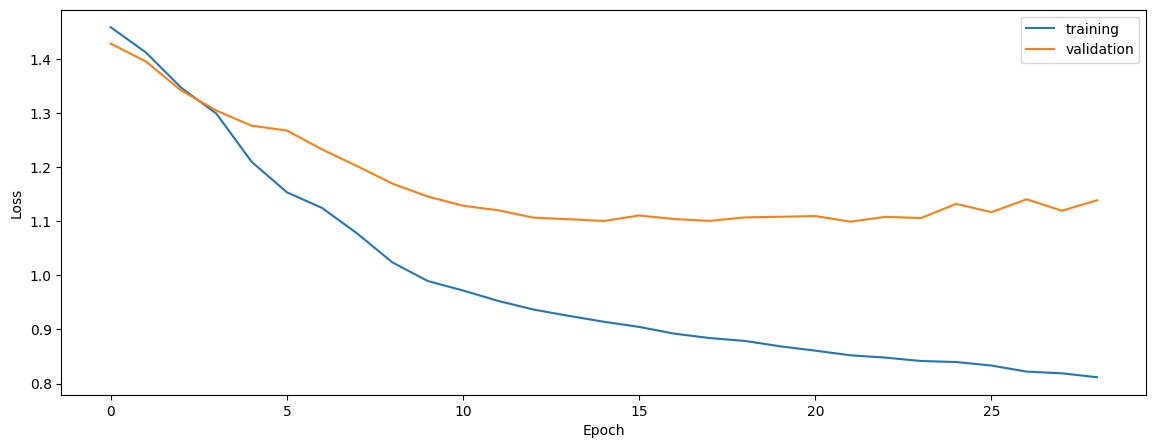

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


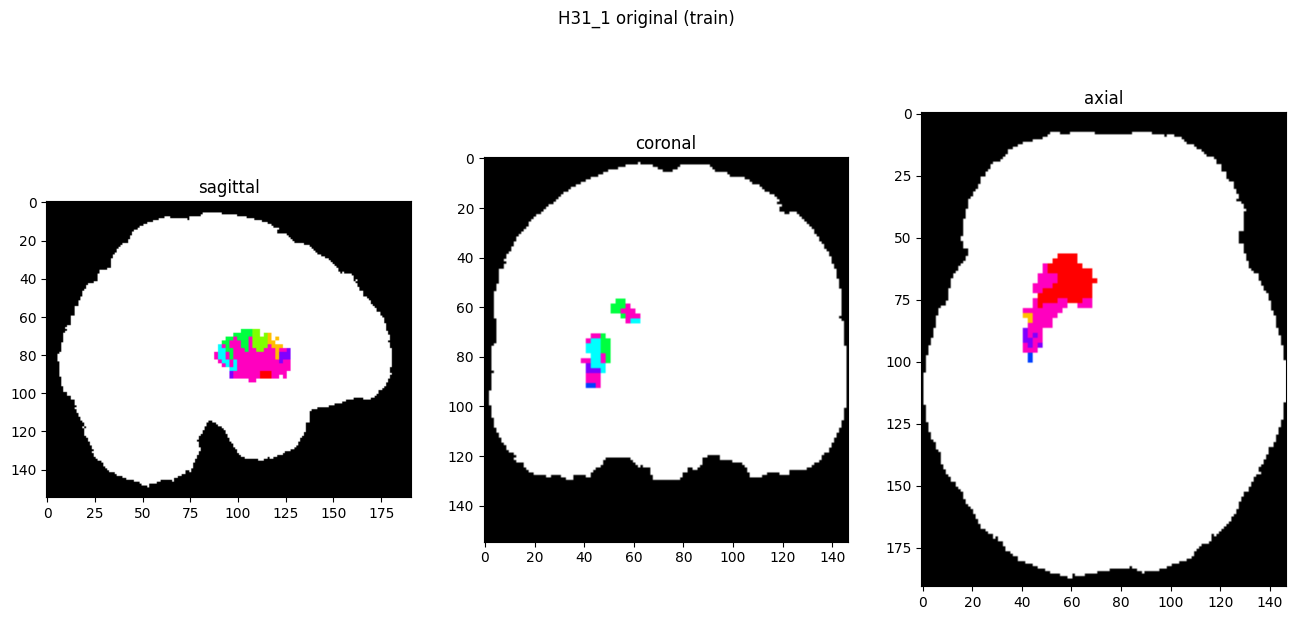

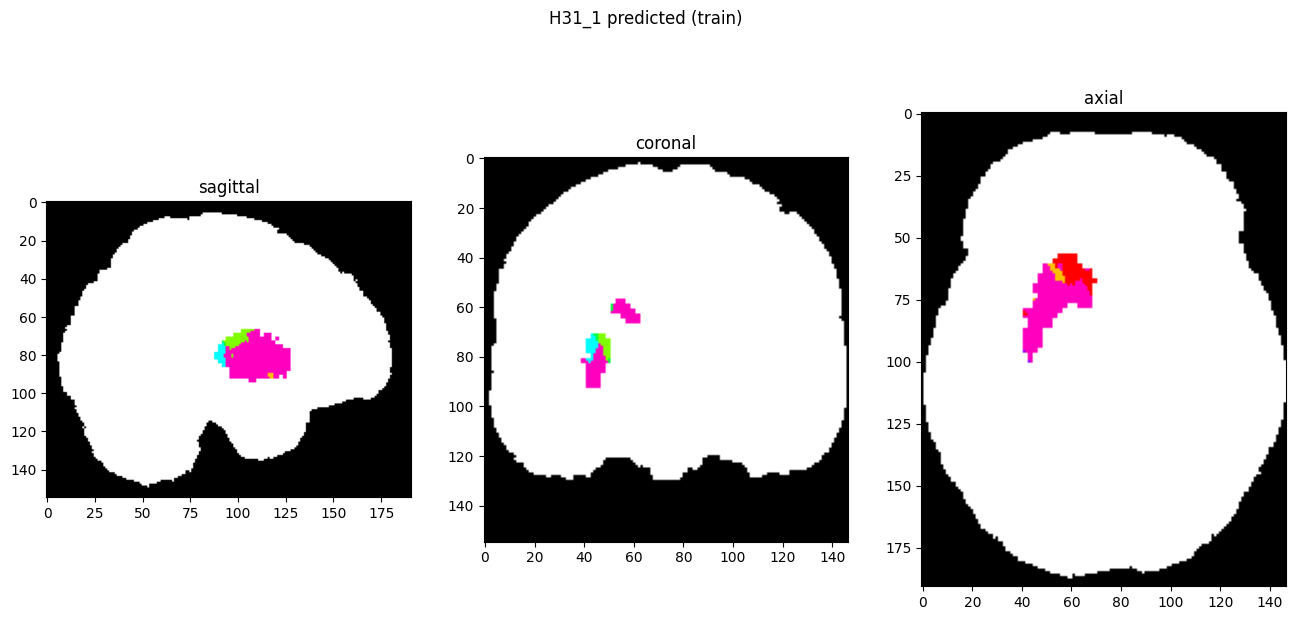

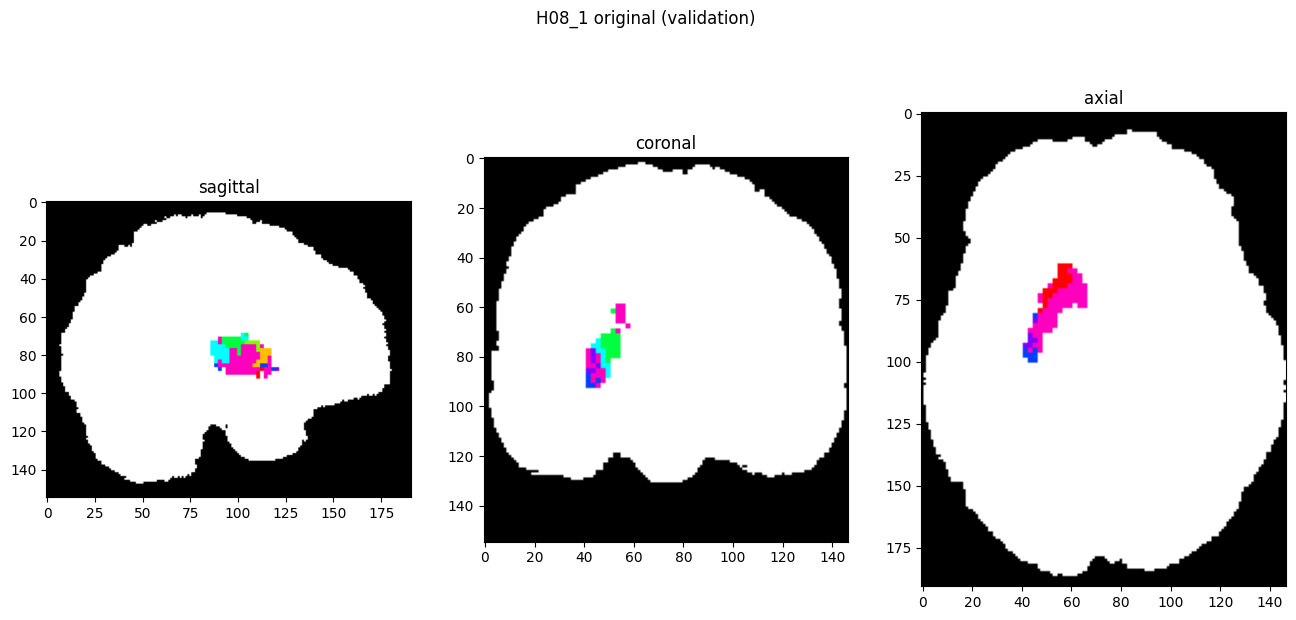

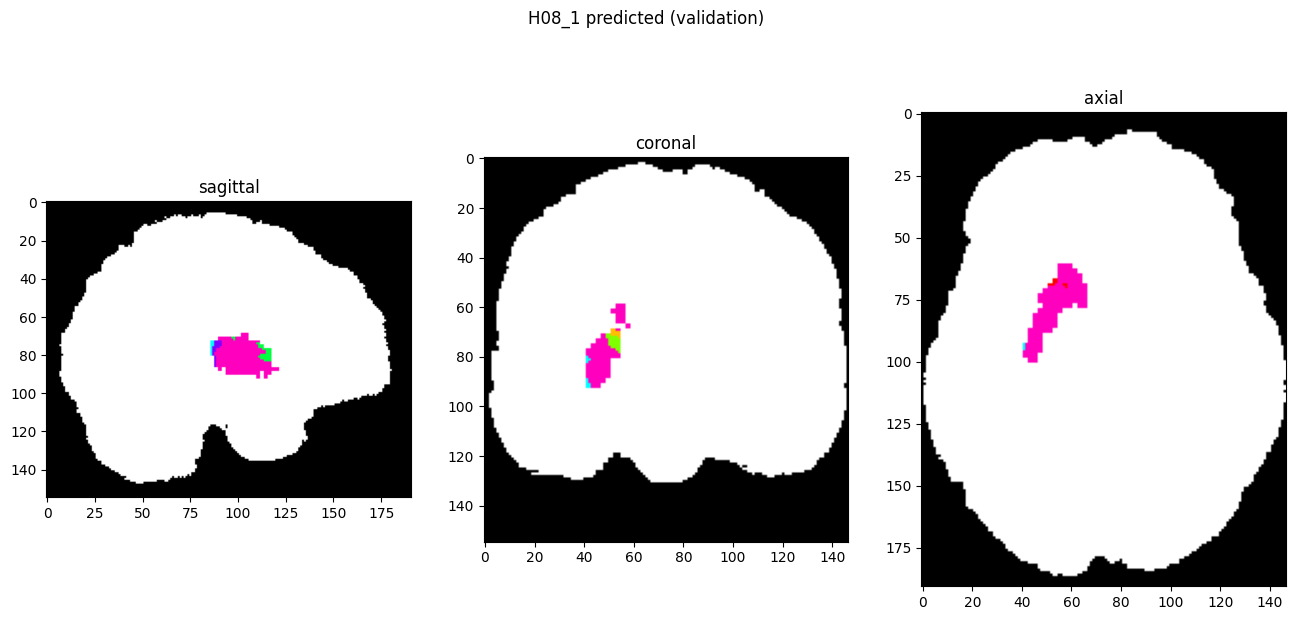

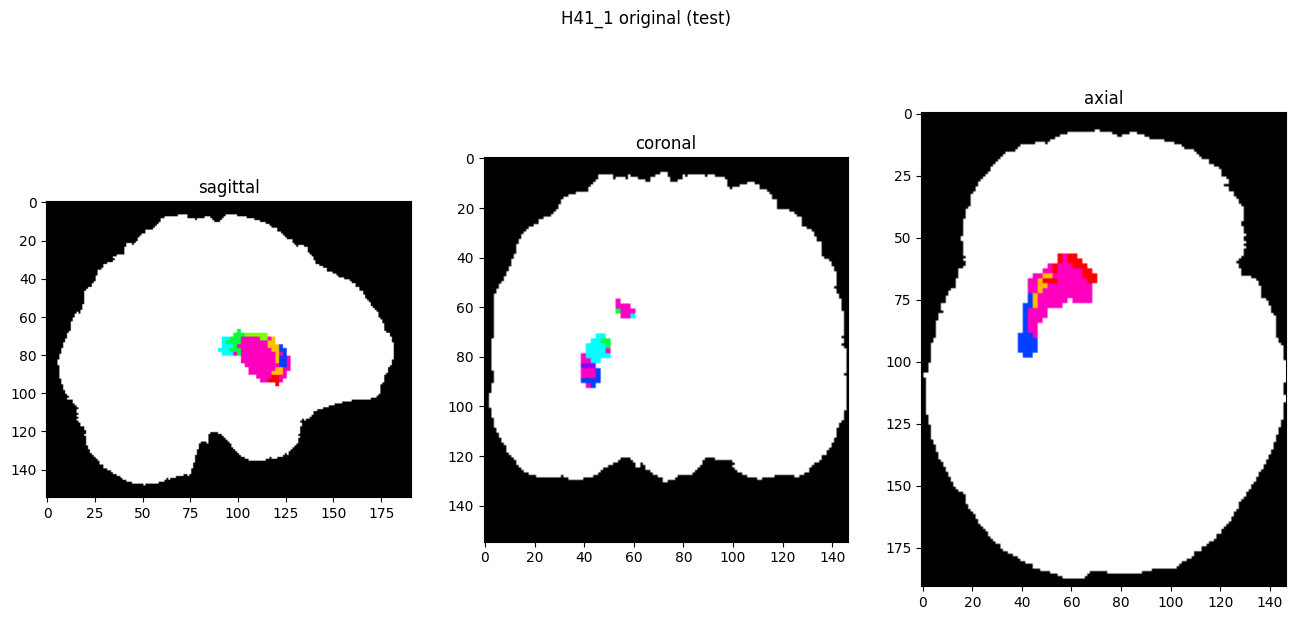

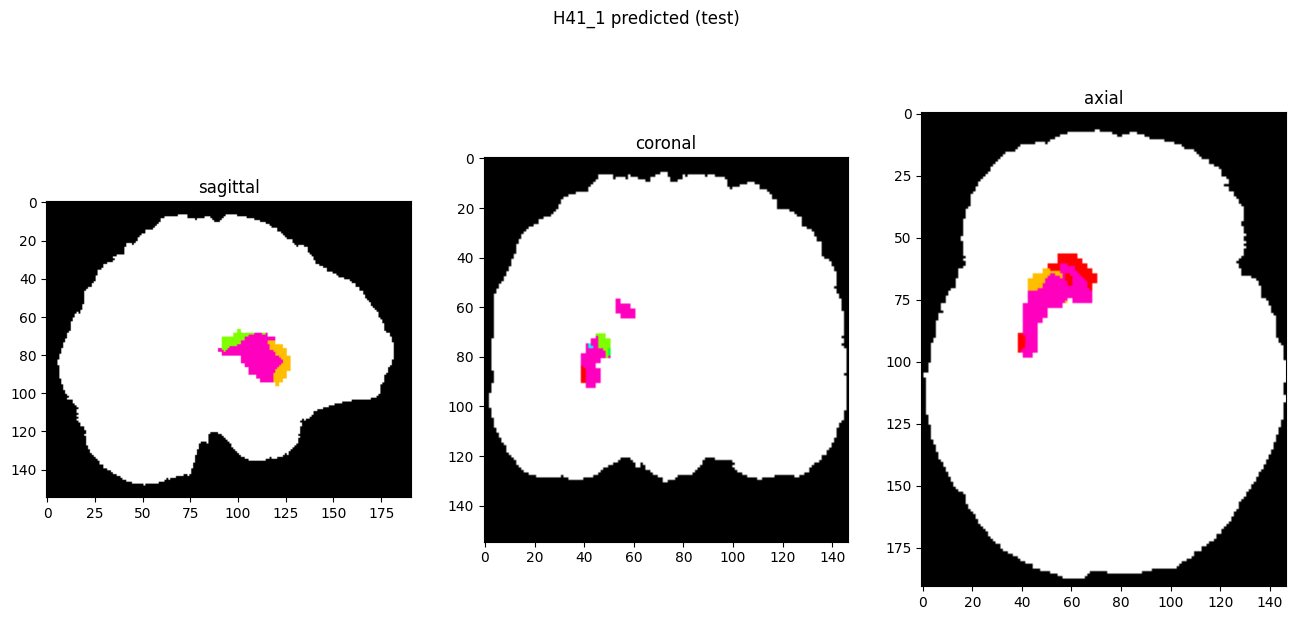

In [10]:
showResults(model, gen, threshold=0)